In [395]:
# regular imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import env
import seaborn as sns
import wrangle as wr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from sklearn.cluster import KMeans
import viz


# default pandas decimal number display format
pd.options.display.float_format = '{:20,.2f}'.format

import warnings
warnings.filterwarnings("ignore")

# Wrangling
from sklearn.model_selection import train_test_split

#evaluate
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression 
from statsmodels.formula.api import ols
import sklearn.preprocessing

#feature engineering
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

In [2]:
# from our acquire.py:
def get_connection(db, user=env.user, host=env.host, password=env.password):
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'
    
sql_query = '''
        SELECT prop.*,
        predictions_2017.logerror,
        predictions_2017.transactiondate,
        air.airconditioningdesc,
        arch.architecturalstyledesc,
        build.buildingclassdesc,
        heat.heatingorsystemdesc,
        land.propertylandusedesc,
        story.storydesc,
        type.typeconstructiondesc
        FROM properties_2017 prop
        JOIN (
            SELECT parcelid, MAX(transactiondate) AS max_transactiondate
            FROM predictions_2017
            GROUP BY parcelid
            ) pred USING(parcelid)
        JOIN predictions_2017 ON pred.parcelid = predictions_2017.parcelid
                          AND pred.max_transactiondate = predictions_2017.transactiondate
        LEFT JOIN airconditioningtype air USING(airconditioningtypeid)
        LEFT JOIN architecturalstyletype arch USING(architecturalstyletypeid)
        LEFT JOIN buildingclasstype build USING(buildingclasstypeid)
        LEFT JOIN heatingorsystemtype heat USING(heatingorsystemtypeid)
        LEFT JOIN propertylandusetype land USING(propertylandusetypeid)
        LEFT JOIN storytype story USING(storytypeid)
        LEFT JOIN typeconstructiontype type USING(typeconstructiontypeid)
        WHERE propertylandusedesc = "Single Family Residential"
            AND transactiondate <= '2017-12-31'
            AND prop.longitude IS NOT NULL
            AND prop.latitude IS NOT NULL
        '''
    
def get_zillow_data():
    df = pd.read_sql(sql_query, get_connection('zillow'))
    df = df.drop(columns='id')
    return df

In [51]:
df = get_zillow_data()

In [52]:
df.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,14297519,NaN,NaN,NaN,3.50,4.00,None,NaN,3.50,NaN,...,"60,590,630,072,012.00",0.03,2017-01-01,None,None,None,None,Single Family Residential,None,None
1,17052889,NaN,NaN,NaN,1.00,2.00,None,NaN,1.00,NaN,...,"61,110,010,023,006.00",0.06,2017-01-01,None,None,None,None,Single Family Residential,None,None
2,14186244,NaN,NaN,NaN,2.00,3.00,None,NaN,2.00,NaN,...,"60,590,218,022,012.00",0.01,2017-01-01,None,None,None,None,Single Family Residential,None,None
3,12177905,NaN,NaN,NaN,3.00,4.00,None,8.00,3.00,NaN,...,"60,373,001,001,006.00",-0.10,2017-01-01,None,None,None,Central,Single Family Residential,None,None
4,12095076,1.00,NaN,NaN,3.00,4.00,None,9.00,3.00,NaN,...,"60,374,608,001,014.00",-0.00,2017-01-01,Central,None,None,Central,Single Family Residential,None,None


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52319 entries, 0 to 52318
Data columns (total 67 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      52319 non-null  int64  
 1   airconditioningtypeid         13615 non-null  float64
 2   architecturalstyletypeid      70 non-null     float64
 3   basementsqft                  47 non-null     float64
 4   bathroomcnt                   52319 non-null  float64
 5   bedroomcnt                    52319 non-null  float64
 6   buildingclasstypeid           0 non-null      object 
 7   buildingqualitytypeid         33654 non-null  float64
 8   calculatedbathnbr             52184 non-null  float64
 9   decktypeid                    389 non-null    float64
 10  finishedfloor1squarefeet      4371 non-null   float64
 11  calculatedfinishedsquarefeet  52238 non-null  float64
 12  finishedsquarefeet12          52073 non-null  float64
 13  f

In [54]:
df.heatingorsystemtypeid.value_counts()

 2.00    20689
 7.00    12526
 6.00      517
20.00       85
13.00       16
 1.00        7
18.00        6
10.00        2
24.00        1
Name: heatingorsystemtypeid, dtype: int64

In [55]:
df.heatingorsystemtypeid.isna().value_counts()

False    33849
True     18470
Name: heatingorsystemtypeid, dtype: int64

In [56]:
df.heatingorsystemdesc.value_counts()

Central       20689
Floor/Wall    12526
Forced air      517
Solar            85
None             16
Baseboard         7
Radiant           6
Gravity           2
Yes               1
Name: heatingorsystemdesc, dtype: int64

In [57]:
df.heatingorsystemdesc.isna().value_counts()

False    33849
True     18470
Name: heatingorsystemdesc, dtype: int64

In [58]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
parcelid,"52,319.00","12,996,817.91","3,350,951.35","10,711,855.00","11,510,167.50","12,578,254.00","14,130,361.00","167,687,839.00"
airconditioningtypeid,"13,615.00",2.44,3.85,1.00,1.00,1.00,1.00,13.00
architecturalstyletypeid,70.00,7.10,2.67,2.00,7.00,7.00,7.00,21.00
basementsqft,47.00,678.98,711.83,38.00,263.50,512.00,809.50,"3,560.00"
bathroomcnt,"52,319.00",2.30,1.02,0.00,2.00,2.00,3.00,18.00
bedroomcnt,"52,319.00",3.30,0.95,0.00,3.00,3.00,4.00,14.00
buildingqualitytypeid,"33,654.00",6.26,1.72,1.00,5.00,6.00,8.00,12.00
calculatedbathnbr,"52,184.00",2.31,1.02,1.00,2.00,2.00,3.00,18.00
decktypeid,389.00,66.00,0.00,66.00,66.00,66.00,66.00,66.00
finishedfloor1squarefeet,"4,371.00","1,546.29",675.34,184.00,"1,151.00","1,410.00","1,760.00","6,912.00"


(-1.0, 1.0)

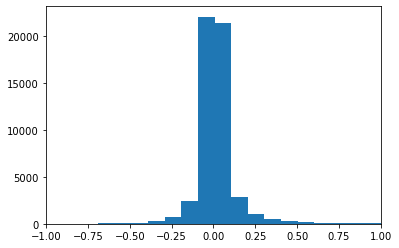

In [59]:
#Distribution of target variable
plt.hist(x=df['logerror'], bins=100)
plt.xlim(-1, 1)

In [60]:
print(f'r0ws: {df.shape[0]}')
print(f'co1umns: {df.shape[1]}')

r0ws: 52319
co1umns: 67


In [61]:
for col in df.columns:
    print(col)
    print(df[col].value_counts())

parcelid
14297519    1
17237669    1
11839030    1
17148095    1
11311690    1
           ..
14138000    1
12026029    1
14212835    1
12213446    1
12826780    1
Name: parcelid, Length: 52319, dtype: int64
airconditioningtypeid
 1.00    11873
13.00     1567
 5.00      159
11.00       16
Name: airconditioningtypeid, dtype: int64
architecturalstyletypeid
 7.00    62
 3.00     3
 2.00     2
21.00     2
 8.00     1
Name: architecturalstyletypeid, dtype: int64
basementsqft
  900.00    2
  640.00    2
  100.00    2
  515.00    2
  273.00    2
  912.00    2
  314.00    1
  819.00    1
1,809.00    1
  604.00    1
  126.00    1
  588.00    1
  786.00    1
  669.00    1
  800.00    1
  396.00    1
  112.00    1
  645.00    1
  384.00    1
1,969.00    1
  252.00    1
  600.00    1
1,218.00    1
  280.00    1
  300.00    1
  224.00    1
  512.00    1
  380.00    1
  204.00    1
  200.00    1
   90.00    1
3,112.00    1
  405.00    1
1,252.00    1
  254.00    1
3,560.00    1
  352.00    1
  168.00

Nulls By Column

Sure, using built in methods is easy enough. But what about getting our nulls by column and nulls by row?

Let's look at nulls by column. Let's start by using .isnull():

In [62]:
df.isnull().head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,False,True,True,True,False,False,True,True,False,True,...,False,False,False,True,True,True,True,False,True,True
1,False,True,True,True,False,False,True,True,False,True,...,False,False,False,True,True,True,True,False,True,True
2,False,True,True,True,False,False,True,True,False,True,...,False,False,False,True,True,True,True,False,True,True
3,False,True,True,True,False,False,True,False,False,True,...,False,False,False,True,True,True,False,False,True,True
4,False,False,True,True,False,False,True,False,False,True,...,False,False,False,False,True,True,False,False,True,True


In [63]:
df.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,14297519,NaN,NaN,NaN,3.50,4.00,None,NaN,3.50,NaN,...,"60,590,630,072,012.00",0.03,2017-01-01,None,None,None,None,Single Family Residential,None,None
1,17052889,NaN,NaN,NaN,1.00,2.00,None,NaN,1.00,NaN,...,"61,110,010,023,006.00",0.06,2017-01-01,None,None,None,None,Single Family Residential,None,None
2,14186244,NaN,NaN,NaN,2.00,3.00,None,NaN,2.00,NaN,...,"60,590,218,022,012.00",0.01,2017-01-01,None,None,None,None,Single Family Residential,None,None
3,12177905,NaN,NaN,NaN,3.00,4.00,None,8.00,3.00,NaN,...,"60,373,001,001,006.00",-0.10,2017-01-01,None,None,None,Central,Single Family Residential,None,None
4,12095076,1.00,NaN,NaN,3.00,4.00,None,9.00,3.00,NaN,...,"60,374,608,001,014.00",-0.00,2017-01-01,Central,None,None,Central,Single Family Residential,None,None


In [64]:
df.isnull().sum()[:50]

parcelid                            0
airconditioningtypeid           38704
architecturalstyletypeid        52249
basementsqft                    52272
bathroomcnt                         0
bedroomcnt                          0
buildingclasstypeid             52319
buildingqualitytypeid           18665
calculatedbathnbr                 135
decktypeid                      51930
finishedfloor1squarefeet        47948
calculatedfinishedsquarefeet       81
finishedsquarefeet12              246
finishedsquarefeet13            52319
finishedsquarefeet15            52319
finishedsquarefeet50            47948
finishedsquarefeet6             52154
fips                                0
fireplacecnt                    45086
fullbathcnt                       135
garagecarcnt                    34335
garagetotalsqft                 34335
hashottuborspa                  50805
heatingorsystemtypeid           18470
latitude                            0
longitude                           0
lotsizesquar

In [65]:
df.shape[0] # Number of rows

52319

In [66]:
(df.isnull().sum()/df.shape[0]*100)[:] # Percentage of nulls in each column

parcelid                                   0.00
airconditioningtypeid                     73.98
architecturalstyletypeid                  99.87
basementsqft                              99.91
bathroomcnt                                0.00
                                   ...         
buildingclassdesc                        100.00
heatingorsystemdesc                       35.30
propertylandusedesc                        0.00
storydesc                                 99.91
typeconstructiondesc                      99.85
Length: 67, dtype: float64

In [67]:
nulls_col = pd.DataFrame({'num_rows_missing': df.isnull().sum(), 
              'percent_rows_missing': (df.isnull().sum() / df.shape[0] * 100)})

nulls_col.sort_values(by='num_rows_missing', ascending=False).head(60)

,num_rows_missing,percent_rows_missing
finishedsquarefeet13,52319,100.00
buildingclasstypeid,52319,100.00
buildingclassdesc,52319,100.00
finishedsquarefeet15,52319,100.00
basementsqft,52272,99.91
storydesc,52272,99.91
storytypeid,52272,99.91
yardbuildingsqft26,52256,99.88
architecturalstyletypeid,52249,99.87
architecturalstyledesc,52249,99.87


In [68]:
df.poolcnt.value_counts()

1.00    11077
Name: poolcnt, dtype: int64

### nulls_by_col function

In [69]:
def nulls_by_col(df):
    num_missing = df.isnull().sum()
    rows = df.shape[0]
    prcnt_miss = num_missing / rows * 100
    cols_missing = pd.DataFrame({'num_rows_missing': num_missing, 'percent_rows_missing': prcnt_miss})
    return cols_missing.sort_values(by='num_rows_missing', ascending=False)

In [70]:
nulls_by_col(df)

,num_rows_missing,percent_rows_missing
finishedsquarefeet13,52319,100.00
buildingclasstypeid,52319,100.00
buildingclassdesc,52319,100.00
finishedsquarefeet15,52319,100.00
basementsqft,52272,99.91
...,...,...
latitude,0,0.00
fips,0,0.00
bedroomcnt,0,0.00
bathroomcnt,0,0.00


Nulls by Row



In [71]:
# look at the number/percent of nulls in each row
df.isnull().sum(axis=1)

0        36
1        33
2        34
3        32
4        29
         ..
52314    34
52315    33
52316    32
52317    32
52318    34
Length: 52319, dtype: int64

In [72]:
#both NaN and None are considered as null
df.head(1)[df.head(1).isna()]

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,...,NaN,NaN,NaN,None,None,None,None,NaN,None,None


In [73]:
#into a percentage:
df.isnull().sum(axis=1) / df.shape[1] * 100

0                      53.73
1                      49.25
2                      50.75
3                      47.76
4                      43.28
                ...         
52314                  50.75
52315                  49.25
52316                  47.76
52317                  47.76
52318                  50.75
Length: 52319, dtype: float64

In [74]:
nulls_row = pd.DataFrame({'num_cols_missing': df.isnull().sum(axis=1),
              'percent_cols_missing': df.isnull().sum(axis=1)/df.shape[1]*100})

nulls_row

,num_cols_missing,percent_cols_missing
0,36,53.73
1,33,49.25
2,34,50.75
3,32,47.76
4,29,43.28
...,...,...
52314,34,50.75
52315,33,49.25
52316,32,47.76
52317,32,47.76


In [75]:
#if we wanted parcel id back in
# nulls_row = df.merge(nulls_row,
#                         left_index=True,
#                         right_index=True)[['parcelid', 'num_cols_missing', 'percent_cols_missing']]

# nulls_row

In [76]:
nulls_row.sort_values(by='num_cols_missing', ascending=False)

,num_cols_missing,percent_cols_missing
28006,48,71.64
8954,48,71.64
41347,47,70.15
13356,46,68.66
21989,45,67.16
...,...,...
44684,24,35.82
83,24,35.82
37444,24,35.82
39391,23,34.33


### nulls_by_row function

In [77]:
def nulls_by_row(df):
    num_missing = df.isnull().sum(axis=1)
    prcnt_miss = num_missing / df.shape[1] * 100
    rows_missing = pd.DataFrame({'num_cols_missing': num_missing, 'percent_cols_missing': prcnt_miss})
#     rows_missing = df.merge(rows_missing,
#                         left_index=True,
#                         right_index=True)[['parcelid', 'num_cols_missing', 'percent_cols_missing']]
    return rows_missing.sort_values(by='num_cols_missing', ascending=False)

In [78]:
nulls_by_row(df)

,num_cols_missing,percent_cols_missing
28006,48,71.64
8954,48,71.64
41347,47,70.15
13356,46,68.66
21989,45,67.16
...,...,...
44684,24,35.82
83,24,35.82
37444,24,35.82
39391,23,34.33


### summarize function

In [79]:
def summarize(df):
    '''
    summarize will take in a single argument (a pandas dataframe) 
    and output to console various statistics on said dataframe, including:
    # .head()
    # .info()
    # .describe()
    # .value_counts()
    # observation of nulls in the dataframe
    '''
    print('SUMMARY REPORT')
    print('=====================================================\n\n')
    print('Dataframe head: ')
    print(df.head(3))
    print('=====================================================\n\n')
    print('Dataframe info: ')
    print(df.info())
    print('=====================================================\n\n')
    print('Dataframe Description: ')
    print(df.describe())
    num_cols = [col for col in df.columns if df[col].dtype != 'O']
    cat_cols = [col for col in df.columns if col not in num_cols]
    print('=====================================================')
    print('DataFrame value counts: ')
    for col in df.columns:
        if col in cat_cols:
            print(df[col].value_counts(), '\n')
        else:
            print(df[col].value_counts(bins=10, sort=False), '\n')
    print('=====================================================')
    print('nulls in dataframe by column: ')
    print(nulls_by_col(df))
    print('=====================================================')
    print('nulls in dataframe by row: ')
    print(nulls_by_row(df))
    print('=====================================================')

In [80]:
summarize(df)

SUMMARY REPORT


Dataframe head: 
   parcelid  airconditioningtypeid  architecturalstyletypeid  basementsqft  \
0  14297519                    NaN                       NaN           NaN   
1  17052889                    NaN                       NaN           NaN   
2  14186244                    NaN                       NaN           NaN   

           bathroomcnt           bedroomcnt buildingclasstypeid  \
0                 3.50                 4.00                None   
1                 1.00                 2.00                None   
2                 2.00                 3.00                None   

   buildingqualitytypeid    calculatedbathnbr  decktypeid  ...  \
0                    NaN                 3.50         NaN  ...   
1                    NaN                 1.00         NaN  ...   
2                    NaN                 2.00         NaN  ...   

    censustractandblock             logerror  transactiondate  \
0 60,590,630,072,012.00                 0.03       201

(1.9800000000000002, 3.9]     5
(3.9, 5.8]                    0
(5.8, 7.7]                   62
(7.7, 9.6]                    1
(9.6, 11.5]                   0
(11.5, 13.4]                  0
(13.4, 15.3]                  0
(15.3, 17.2]                  0
(17.2, 19.1]                  0
(19.1, 21.0]                  2
Name: architecturalstyletypeid, dtype: int64 

(34.477000000000004, 390.2]    20
(390.2, 742.4]                 13
(742.4, 1094.6]                 7
(1094.6, 1446.8]                3
(1446.8, 1799.0]                0
(1799.0, 2151.2]                2
(2151.2, 2503.4]                0
(2503.4, 2855.6]                0
(2855.6, 3207.8]                1
(3207.8, 3560.0]                1
Name: basementsqft, dtype: int64 

(-0.019, 1.8]    10494
(1.8, 3.6]       37337
(3.6, 5.4]        3714
(5.4, 7.2]         679
(7.2, 9.0]          85
(9.0, 10.8]          5
(10.8, 12.6]         3
(12.6, 14.4]         1
(14.4, 16.2]         0
(16.2, 18.0]         1
Name: bathroomcnt, dtype: in

(-48791.03799999999, 4895364.7]    52212
(4895364.7, 9790568.4]                86
(9790568.4, 14685772.1]               13
(14685772.1, 19580975.8]               5
(19580975.8, 24476179.5]               1
(24476179.5, 29371383.2]               0
(29371383.2, 34266586.9]               0
(34266586.9, 39161790.6]               0
(39161790.6, 44056994.3]               0
(44056994.3, 48952198.0]               1
Name: landtaxvaluedollarcnt, dtype: int64 

(-537.411, 58708.192]       52117
(58708.192, 117367.204]       165
(117367.204, 176026.216]       19
(176026.216, 234685.228]        9
(234685.228, 293344.24]         4
(293344.24, 352003.252]         0
(352003.252, 410662.264]        0
(410662.264, 469321.276]        0
(469321.276, 527980.288]        0
(527980.288, 586639.3]          1
Name: taxamount, dtype: int64 

Y    2068
Name: taxdelinquencyflag, dtype: int64 

(3.904, 13.5]     384
(13.5, 23.0]     1683
(23.0, 32.5]        0
(32.5, 42.0]        0
(42.0, 51.5]        0
(51.5, 61.0] 

In [81]:
#remove columns
def remove_columns(df, cols_to_remove):
    df = df.drop(columns = cols_to_remove)
    return df

In [82]:
#columns to remove, no use in model, mostly, null, repreated features
#cols_to_remove = ['buildingqualitytypeid','calculatedbathnbr','finishedsquarefeet12','fullbathcnt','heatingorsystemtypeid','roomcnt','unitcnt','propertyzoningdesc']

In [83]:
# df = remove_columns(df, cols_to_remove)

In [84]:
#handle missing values
def handle_missing_values(df, prop_required_columns =0.87, prop_required_row=0.87):
    threshold = int(round(prop_required_columns * len(df.index), 0))
    #axis 1 : drop columns that have missing values
    df = df.dropna(axis=1, thresh=threshold)
    threshold = int(round(prop_required_row * len(df.columns),0))
    #axis 0 : drop rows that have missing values
    df = df.dropna(axis=0, thresh=threshold)
    return df

In [85]:
handle_missing_values(df, prop_required_columns =0.87, prop_required_row=0.87)


,parcelid,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,latitude,longitude,...,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,propertylandusedesc
0,14297519,3.50,4.00,3.50,"3,100.00","3,100.00","6,059.00",3.00,"33,634,931.00","-117,869,207.00",...,"1,998.00","485,713.00","1,023,282.00","2,016.00","537,569.00","11,013.72","60,590,630,072,012.00",0.03,2017-01-01,Single Family Residential
1,17052889,1.00,2.00,1.00,"1,465.00","1,465.00","6,111.00",1.00,"34,449,266.00","-119,281,531.00",...,"1,967.00","88,000.00","464,000.00","2,016.00","376,000.00","5,672.48","61,110,010,023,006.00",0.06,2017-01-01,Single Family Residential
2,14186244,2.00,3.00,2.00,"1,243.00","1,243.00","6,059.00",2.00,"33,886,168.00","-117,823,170.00",...,"1,962.00","85,289.00","564,778.00","2,016.00","479,489.00","6,488.30","60,590,218,022,012.00",0.01,2017-01-01,Single Family Residential
3,12177905,3.00,4.00,3.00,"2,376.00","2,376.00","6,037.00",3.00,"34,245,180.00","-118,240,722.00",...,"1,970.00","108,918.00","145,143.00","2,016.00","36,225.00","1,777.51","60,373,001,001,006.00",-0.10,2017-01-01,Single Family Residential
4,12095076,3.00,4.00,3.00,"2,962.00","2,962.00","6,037.00",3.00,"34,145,202.00","-118,179,824.00",...,"1,950.00","276,684.00","773,303.00","2,016.00","496,619.00","9,516.26","60,374,608,001,014.00",-0.00,2017-01-01,Single Family Residential
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52314,12412492,2.00,4.00,2.00,"1,633.00","1,633.00","6,037.00",2.00,"33,870,815.00","-118,070,858.00",...,"1,962.00","125,466.00","346,534.00","2,016.00","221,068.00","4,175.08","60,375,548,022,001.00",0.00,2017-09-19,Single Family Residential
52315,11000655,2.00,2.00,2.00,"1,286.00","1,286.00","6,037.00",2.00,"34,245,368.00","-118,282,383.00",...,"1,940.00","70,917.00","354,621.00","2,016.00","283,704.00","4,478.43","60,371,014,003,002.00",0.02,2017-09-20,Single Family Residential
52316,17239384,2.00,4.00,2.00,"1,612.00","1,612.00","6,111.00",2.00,"34,300,140.00","-118,706,327.00",...,"1,964.00","50,683.00","67,205.00","2,016.00","16,522.00","1,107.48","61,110,084,022,016.00",0.01,2017-09-21,Single Family Residential
52317,12773139,1.00,3.00,1.00,"1,032.00","1,032.00","6,037.00",1.00,"34,040,895.00","-118,038,169.00",...,"1,954.00","32,797.00","49,546.00","2,016.00","16,749.00",876.43,"60,374,338,022,005.00",0.04,2017-09-21,Single Family Residential


In [86]:
# combining everything in a cleaning function:
def data_prep(df, cols_to_remove=[], prop_required_column=0.87, prop_required_row=0.87):
    df = remove_columns(df, cols_to_remove)
    df = handle_missing_values(df, prop_required_column, prop_required_row)
    return df

In [87]:
df = data_prep(df, cols_to_remove = ['airconditioningtypeid',
 'architecturalstyletypeid',
 'buildingclasstypeid',
 'buildingqualitytypeid',
 'calculatedbathnbr',
 'decktypeid',
 'finishedfloor1squarefeet',
 'finishedsquarefeet12',
 'finishedsquarefeet13',
 'finishedsquarefeet15',
 'finishedsquarefeet50',
 'finishedsquarefeet6',
 'garagetotalsqft',
 'hashottuborspa',
 'heatingorsystemtypeid',
 'poolsizesum',
 'pooltypeid10',
 'pooltypeid2',
 'pooltypeid7',
 'propertycountylandusecode',
 'propertylandusetypeid',
 'propertyzoningdesc',
 'rawcensustractandblock',
 'roomcnt',
 'storytypeid',
 'threequarterbathnbr',
 'typeconstructiontypeid',
 'unitcnt',
 'yardbuildingsqft17',
 'yardbuildingsqft26',
 'numberofstories',
 'fireplaceflag',
 'assessmentyear',
 'taxdelinquencyflag',
 'taxdelinquencyyear',
 'censustractandblock',
 'architecturalstyledesc',
 'buildingclassdesc',
 'propertylandusedesc',
 'regionidneighborhood',                                   
 'storydesc',
 'typeconstructiondesc'], prop_required_column=0.15, prop_required_row=0.15)

In [88]:
df.columns.values.tolist()

['parcelid',
 'bathroomcnt',
 'bedroomcnt',
 'calculatedfinishedsquarefeet',
 'fips',
 'fullbathcnt',
 'garagecarcnt',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'poolcnt',
 'regionidcity',
 'regionidcounty',
 'regionidzip',
 'yearbuilt',
 'structuretaxvaluedollarcnt',
 'taxvaluedollarcnt',
 'landtaxvaluedollarcnt',
 'taxamount',
 'logerror',
 'transactiondate',
 'airconditioningdesc',
 'heatingorsystemdesc']

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52319 entries, 0 to 52318
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      52319 non-null  int64  
 1   bathroomcnt                   52319 non-null  float64
 2   bedroomcnt                    52319 non-null  float64
 3   calculatedfinishedsquarefeet  52238 non-null  float64
 4   fips                          52319 non-null  float64
 5   fullbathcnt                   52184 non-null  float64
 6   garagecarcnt                  17984 non-null  float64
 7   latitude                      52319 non-null  float64
 8   longitude                     52319 non-null  float64
 9   lotsizesquarefeet             51953 non-null  float64
 10  poolcnt                       11077 non-null  float64
 11  regionidcity                  51283 non-null  float64
 12  regionidcounty                52319 non-null  float64
 13  r

In [98]:
df = clean_and_prep(df)

In [99]:
df.isna().sum()

parcelid                               0
bathrooms                              0
bedrooms                               0
sqft                                   0
fips                                   0
fullbathcnt                            0
garagecarcnt                           0
latitude                               0
longitude                              0
lotsizesquarefeet                      0
poolcnt                                0
regionidcity                           0
regionidcounty                         0
regionidzip                            0
yearbuilt                              0
structuretaxvaluedollarcnt             0
home_value                             0
landtaxvaluedollarcnt                  0
taxamount                              0
logerror                               0
transactiondate                        0
airconditioningdesc                    0
heatingorsystemdesc                    0
home_value_structure_tax_difference    0
hvs_pct         

In [104]:
def optimize_types(df):
# Convert some columns to integers, optimize types
# # fips, yearbuilt, and bedrooms can be integers   
    df["fips"] = df["fips"].astype(str)
    df["yearbuilt"] = df["yearbuilt"].astype(int)
    df["bedrooms"] = df["bedrooms"].astype(int)
    df["bathrooms"] = df["bathrooms"].astype(int)
    df["home_value"] = df["home_value"].astype(int)
    df["garagecarcnt"] = df["garagecarcnt"].astype(int)
    df["poolcnt"] = df["poolcnt"].astype(int)
#   df["heatingorsystemdesc"] = df["heatingorsystemdesc"].astype(int)
    df["airconditioning_encoded"] = df["airconditioning_encoded"].astype(int)
    df["sqft"] = df["sqft"].astype(int)
    df["home_value_structure_tax_difference"] = df["home_value_structure_tax_difference"].astype(int)
    df["taxamount"] = df["taxamount"].astype(int)
    df["landtaxvaluedollarcnt"] = df["landtaxvaluedollarcnt"].astype(int)
    df["structuretaxvaluedollarcnt"] = df["structuretaxvaluedollarcnt"].astype(int)
    df["regionidzip"] = df["regionidzip"].astype(int)
    df["lotsizesquarefeet"] = df["lotsizesquarefeet"].astype(int)
    return df

In [97]:
def clean_and_prep(df):
##rename some columns for ease of use
    df = df.rename(columns={"bedroomcnt": "bedrooms", "bathroomcnt": "bathrooms", "calculatedfinishedsquarefeet": "sqft","taxvaluedollarcnt": "home_value"})
    
#remove homes with zero beds
    df = df[df.bedrooms != 0]
    
##filled null/Nonetype with 'None' or '0'
    df.heatingorsystemdesc = df.heatingorsystemdesc.fillna('None')
    df.airconditioningdesc = df.airconditioningdesc.fillna('None')
    df.poolcnt = df.poolcnt.fillna('0')
    df.garagecarcnt = df.garagecarcnt.fillna('0')
    
#feature engineering
    df['home_value_structure_tax_difference'] = (df['home_value']-df['structuretaxvaluedollarcnt'])
    df['hvs_pct'] = (df['home_value_structure_tax_difference']/df['home_value'])
    df['taxrate'] = (df['taxamount']/df['home_value'])
    df['age'] = 2017 - df.yearbuilt
    df['cost_per_sqft'] = (df['home_value']/df['sqft']).round(2)
    df['sqft_room_ratio'] = (df['sqft']/(df['bedrooms']+df['bathrooms'])).round(2)
    mapping = {"None" : "0",
                     "Central" : "2",
                     "Yes" : "1",
                     "Wall Unit" : "1",
                     }
    df['airconditioning_encoded'] = df['airconditioningdesc'].map(mapping)

#impute nulls with tax rate mean times home value
    df.structuretaxvaluedollarcnt = df.structuretaxvaluedollarcnt.fillna(df['home_value']*df['hvs_pct'].mean())
    
#impute 4 missing values for taxamount using mean taxrate of feature engineering
    df.taxamount = df.taxamount.fillna(df['home_value']*df['taxrate'].mean())
    
#impute nulls with regionidcity mode of 12447
    df['regionidcity'] = df.regionidcity.fillna(12447)
    
#impute missing values with below
    df.home_value_structure_tax_difference = df.home_value_structure_tax_difference.fillna(df['home_value']-df['structuretaxvaluedollarcnt'])
    
#impute missing values with below
    df.hvs_pct = df.hvs_pct.fillna(df['home_value_structure_tax_difference']/df['home_value'])
    
#impute nulls with mean year built
    df.yearbuilt = df.yearbuilt.fillna(df['yearbuilt'].mean())
    
#impute nulls with mode of regionidzip
    df.regionidzip = df.regionidzip.fillna(df.regionidzip.mode())
    
##replace nulls with median lot size
    df.lotsizesquarefeet = df.lotsizesquarefeet.fillna(df.lotsizesquarefeet.median())
    
##impute fullbathcnt with value from df.bathrooms
    df.fullbathcnt = df.fullbathcnt.fillna(df.bathrooms)                                                   
                                                       
##drop remaining handful of nulls
    df = df.dropna()                                                   
    return df

In [227]:
b

In [362]:
# #dummy encode quarter

# quarter_df = pd.get_dummies(df.quarter)
# df = pd.concat([df, quarter_df],axis=1)
# df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52119 entries, 0 to 52318
Data columns (total 38 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   parcelid                             52119 non-null  int64  
 1   bathrooms                            52119 non-null  int32  
 2   bedrooms                             52119 non-null  int32  
 3   sqft                                 52119 non-null  int32  
 4   fips                                 52119 non-null  object 
 5   fullbathcnt                          52119 non-null  float64
 6   garagecarcnt                         52119 non-null  int32  
 7   latitude                             52119 non-null  float64
 8   longitude                            52119 non-null  float64
 9   lotsizesquarefeet                    52119 non-null  float64
 10  poolcnt                              52119 non-null  int32  
 11  regionidcity                

In [179]:
def get_counties():
    '''
    This function will create dummy variables out of the original fips column. 
    And return a dataframe with all of the original columns except regionidcounty.
    We will keep fips column for data validation after making changes. 
    New columns added will be 'LA', 'Orange', and 'Ventura' which are boolean 
    The fips ids are renamed to be the name of the county each represents. 
    '''
    # create dummy vars of fips id
    county_df = pd.get_dummies(df.fips)
    # rename columns by actual county name
    county_df.columns = ['LA', 'Orange', 'Ventura']
    # concatenate the dataframe with the 3 county columns to the original dataframe
    df_dummies = pd.concat([df, county_df], axis = 1)
    # drop regionidcounty and fips columns
    df_dummies = df_dummies.drop(columns = ['regionidcounty'])
    return df_dummies

In [190]:
df = get_counties()
df.head().T

In [184]:
def handle_outliers(df):
    """Manually handle outliers that do not represent properties likely for 99% of buyers and zillow visitors"""
    df = df[df.bathrooms <= 7]
    
    df = df[df.bedrooms <= 6]

    df = df[df.home_value < 3_000_000]

    df.drop(df.loc[df.sqft >10000].index, inplace=True)

    df.drop(df.loc[df['bedrooms']==0].index, inplace=True)
    
    df.drop(df.loc[df['bathrooms']==0].index, inplace=True)

    return df

In [185]:
handle_outliers(df)

,parcelid,bathrooms,bedrooms,sqft,fips,fullbathcnt,garagecarcnt,latitude,longitude,lotsizesquarefeet,...,taxrate,age,cost_per_sqft,sqft_room_ratio,airconditioning_encoded,luxury_score,luxury_sqft_per_age,LA,Orange,Ventura
0,14297519,3,4,3100,6059.0,3.00,2,"33,634,931.00","-117,869,207.00","4,506.00",...,0.01,19.00,330.09,413.33,0,9,"1,468.42",0,1,0
1,17052889,1,2,1465,6111.0,1.00,1,"34,449,266.00","-119,281,531.00","12,647.00",...,0.01,50.00,316.72,488.33,0,4,117.20,0,0,1
2,14186244,2,3,1243,6059.0,2.00,2,"33,886,168.00","-117,823,170.00","8,432.00",...,0.01,55.00,454.37,248.60,0,8,180.80,0,1,0
3,12177905,3,4,2376,6037.0,3.00,0,"34,245,180.00","-118,240,722.00","13,038.00",...,0.01,47.00,61.09,339.43,0,8,404.43,1,0,0
4,12095076,3,4,2962,6037.0,3.00,0,"34,145,202.00","-118,179,824.00","63,000.00",...,0.01,67.00,261.07,423.14,2,10,442.09,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52314,12412492,2,4,1633,6037.0,2.00,0,"33,870,815.00","-118,070,858.00","4,630.00",...,0.01,55.00,212.21,272.17,0,6,178.15,1,0,0
52315,11000655,2,2,1286,6037.0,2.00,0,"34,245,368.00","-118,282,383.00","47,405.00",...,0.01,77.00,275.76,321.50,0,4,66.81,1,0,0
52316,17239384,2,4,1612,6111.0,2.00,2,"34,300,140.00","-118,706,327.00","12,105.00",...,0.02,53.00,41.69,268.67,0,8,243.32,0,0,1
52317,12773139,1,3,1032,6037.0,1.00,0,"34,040,895.00","-118,038,169.00","5,074.00",...,0.02,63.00,48.01,258.00,2,6,98.29,1,0,0


In [189]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52119 entries, 0 to 52318
Data columns (total 35 columns):
 #   Column                               Non-Null Count  Dtype        
---  ------                               --------------  -----        
 0   parcelid                             52119 non-null  int64        
 1   bathrooms                            52119 non-null  int32        
 2   bedrooms                             52119 non-null  int32        
 3   sqft                                 52119 non-null  int32        
 4   fips                                 52119 non-null  object       
 5   fullbathcnt                          52119 non-null  float64      
 6   garagecarcnt                         52119 non-null  int32        
 7   latitude                             52119 non-null  float64      
 8   longitude                            52119 non-null  float64      
 9   lotsizesquarefeet                    52119 non-null  float64      
 10  poolcnt               

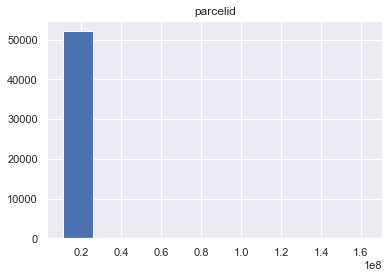

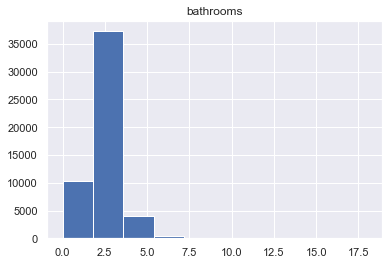

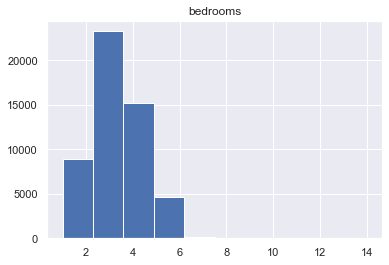

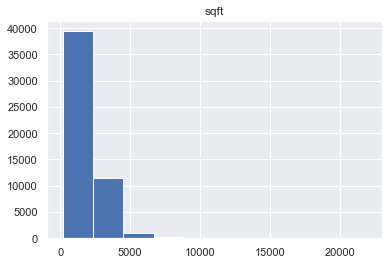

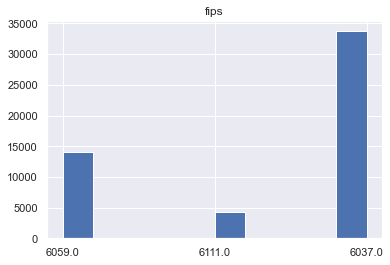

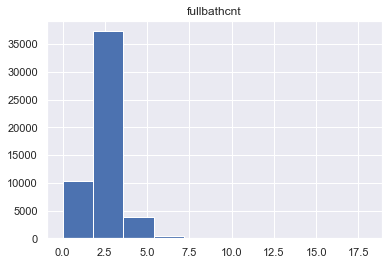

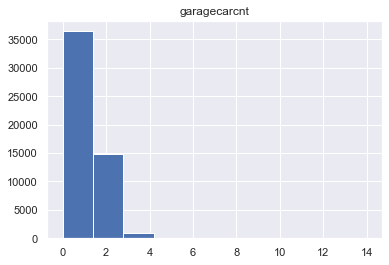

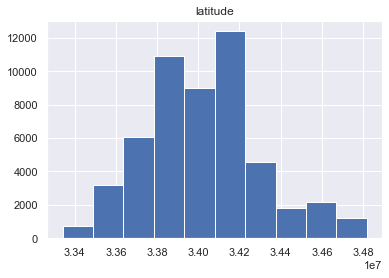

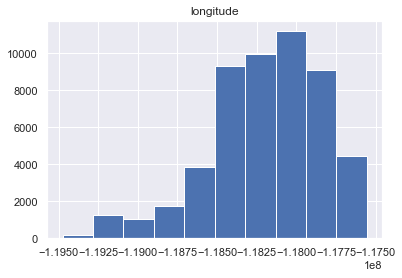

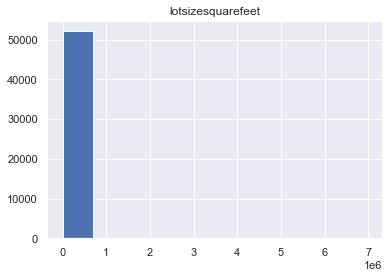

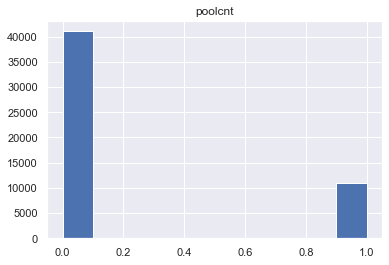

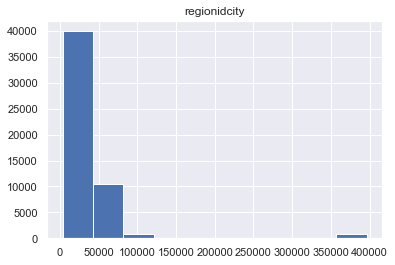

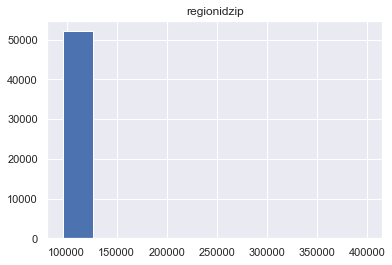

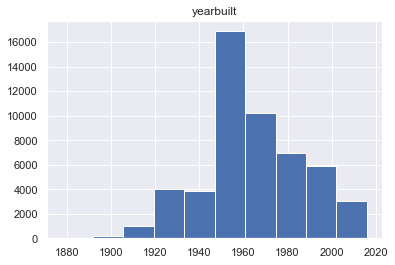

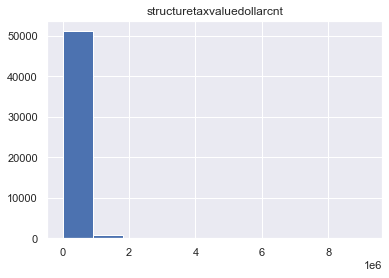

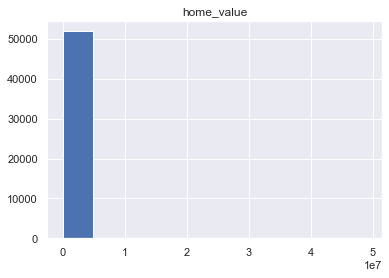

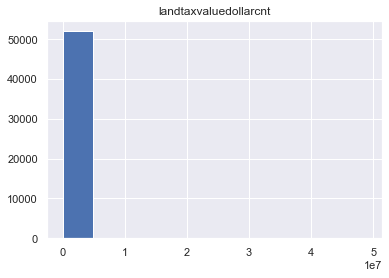

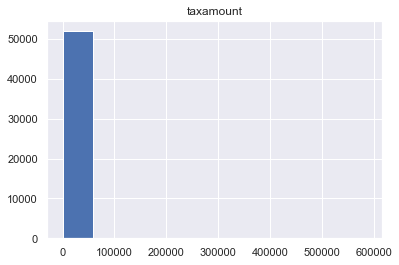

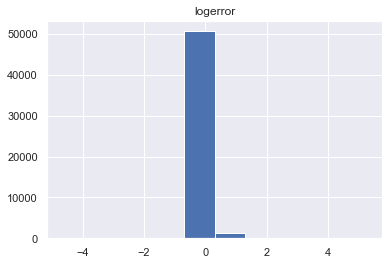

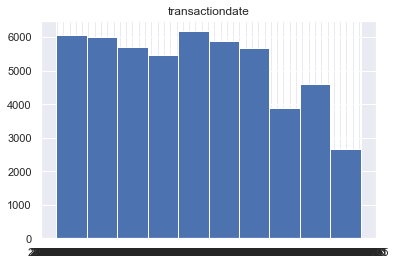

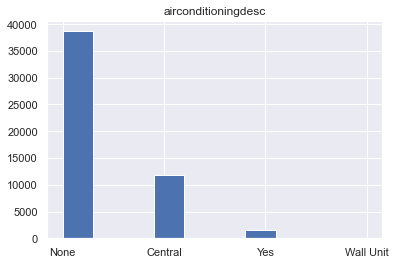

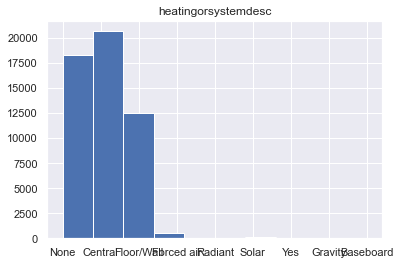

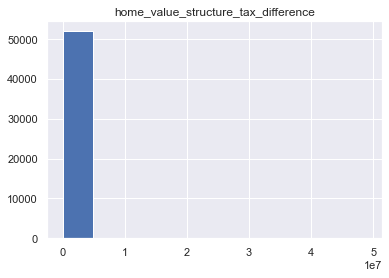

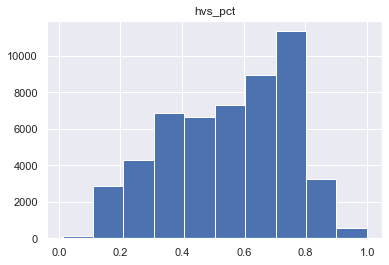

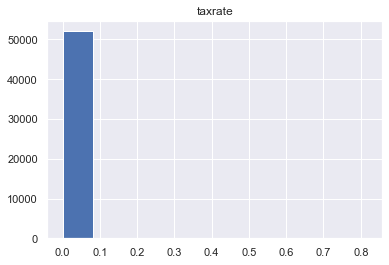

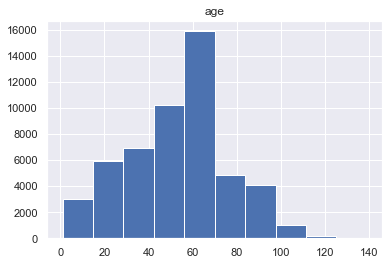

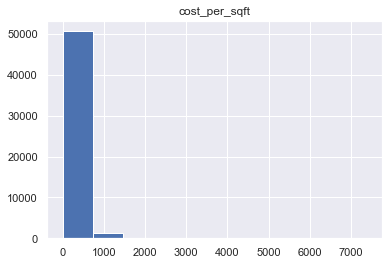

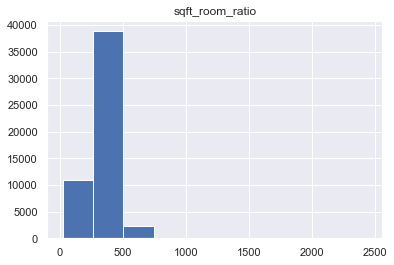

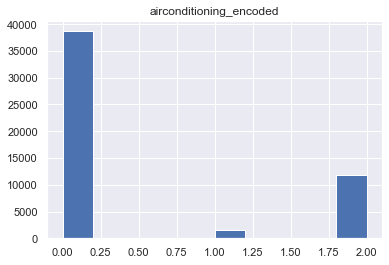

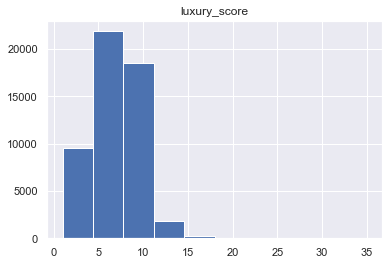

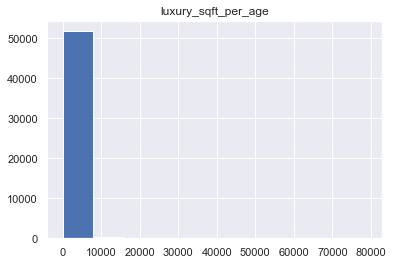

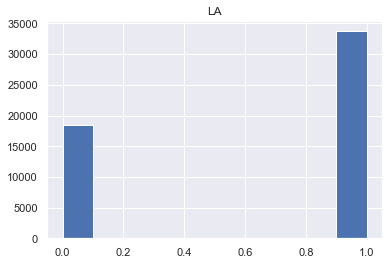

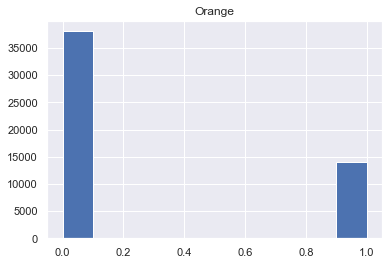

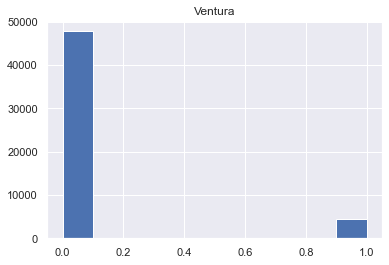

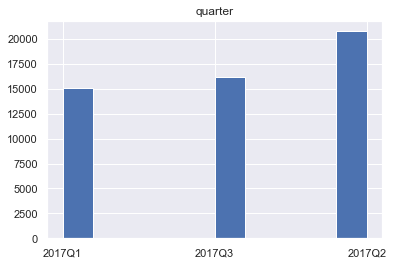

In [197]:
for col in df.columns:
    plt.hist(df[col])
    plt.title(col)
    plt.show()

### Exploration
    - split data
    - visual and graphical analysis
    - hypothesis testing on questions raised
    - key findings/summary/
    - prepped for clustering with scaled data

In [196]:
# df.quarter=df.quarter.astype(str)
# df.info()

In [351]:
def split(df, target_var):
    '''
    This function takes in the dataframe and target variable name as arguments and then
    splits the dataframe into train (56%), validate (24%), & test (20%)
    It will return a list containing the following dataframes: train (for exploration), 
    X_train, X_validate, X_test, y_train, y_validate, y_test
    '''
    # split df into train_validate (80%) and test (20%)
    train_validate, test = train_test_split(df, test_size=.20, random_state=13)
    # split train_validate into train(70% of 80% = 56%) and validate (30% of 80% = 24%)
    train, validate = train_test_split(train_validate, test_size=.3, random_state=13)

    # create X_train by dropping the target variable 
    X_train = train.drop(columns=[target_var])
    # create y_train by keeping only the target variable.
    y_train = train[[target_var]]

    # create X_validate by dropping the target variable 
    X_validate = validate.drop(columns=[target_var])
    # create y_validate by keeping only the target variable.
    y_validate = validate[[target_var]]

    # create X_test by dropping the target variable 
    X_test = test.drop(columns=[target_var])
    # create y_test by keeping only the target variable.
    y_test = test[[target_var]]

#     partitions = [train, X_train, X_validate, X_test, y_train, y_validate, y_test]
    return train, X_train, X_validate, X_test, y_train, y_validate, y_test

In [352]:
train, X_train, X_validate, X_test, y_train, y_validate, y_test = split(df, target_var='logerror')

In [350]:
# partitions = split(df, target_var='logerror')

In [353]:

train['logerror_bins'] = pd.cut(train.logerror, [-5, -.2, -.05, .05, .2, 4])


In [354]:
train.logerror_bins.value_counts()

(-0.05, 0.05]    18941
(0.05, 0.2]       4741
(-0.2, -0.05]     3518
(0.2, 4.0]        1320
(-5.0, -0.2]       665
Name: logerror_bins, dtype: int64

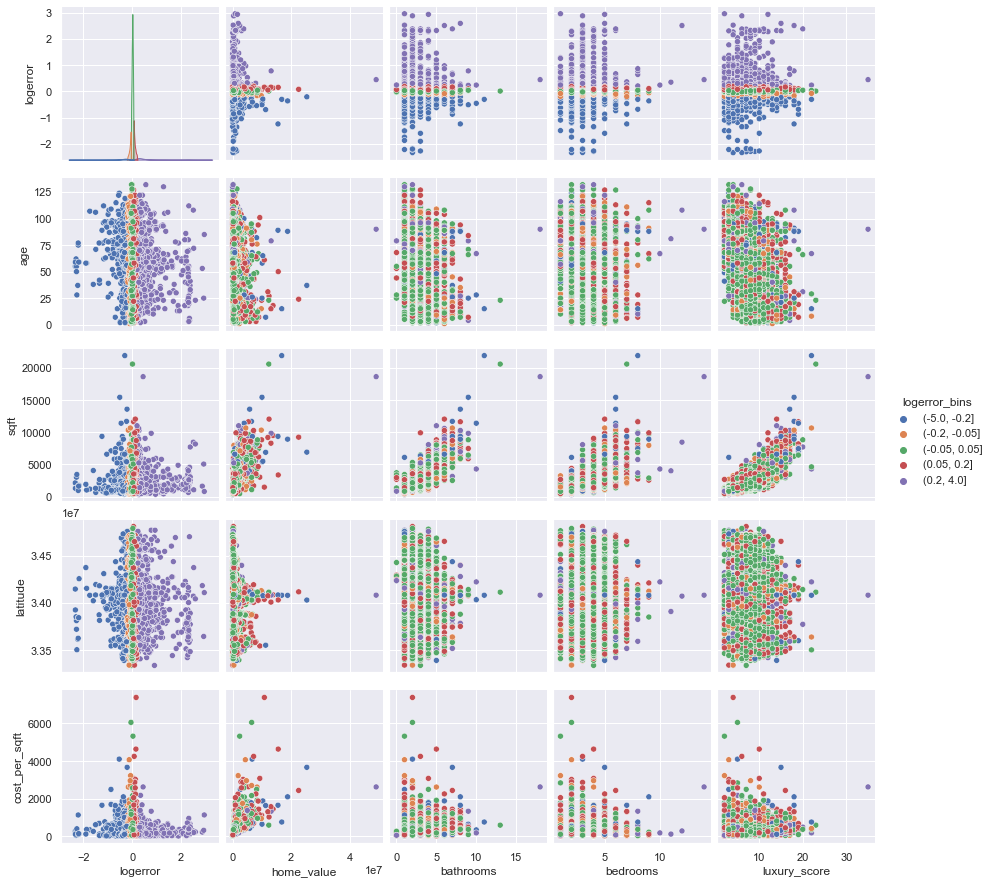

In [232]:
sns.pairplot(data = train, hue = 'logerror_bins', 
             x_vars = ['logerror', 'home_value', 'bathrooms', 'bedrooms', 
                       'luxury_score'],
             y_vars = ['logerror', 'age', 'sqft', 'latitude', 'cost_per_sqft'])

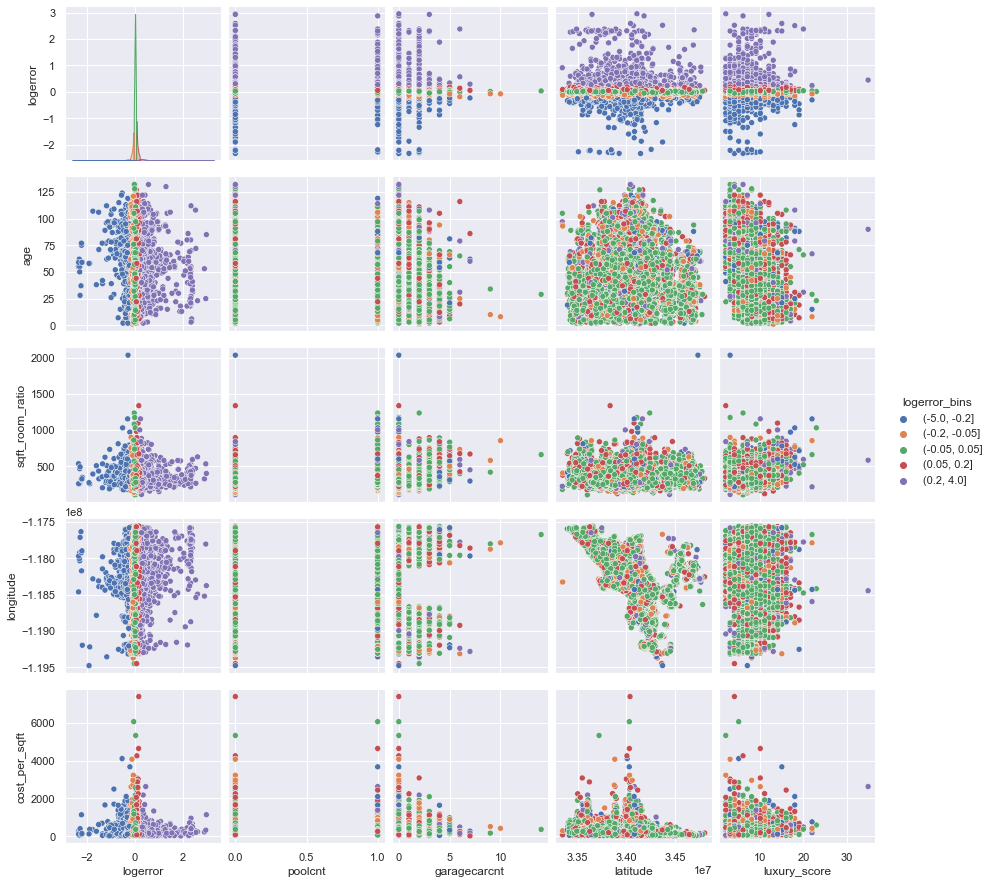

In [233]:
sns.pairplot(data = train, hue = 'logerror_bins', 
             x_vars = ['logerror', 'poolcnt', 'garagecarcnt', 'latitude', 
                       'luxury_score'],
             y_vars = ['logerror', 'age', 'sqft_room_ratio', 'longitude', 'cost_per_sqft'])

    1. appears that larger longitude(further west) correllates to lower error
    2. cost per sq ft is lower there is correlation to higher error
    3.lower sq ft room ratio points to higher error
    4. age is interesting, looks like there are periods of years that have higher error
    5. pockets of higher cost per sqft at diff longitudes

<Figure size 1080x576 with 0 Axes>

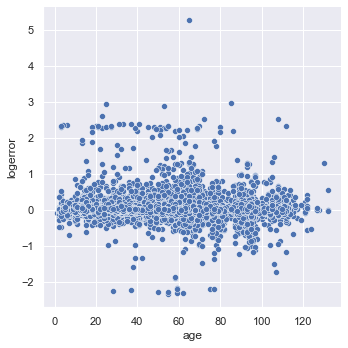

In [256]:

sns.relplot(x=train.age, y=df.logerror, data=train, palette='deep', legend='auto', kind='scatter', height=5, aspect=1, facet_kws=None, units=None, )

1.  looks like there are spikes in error at particular age marks, 40 60 80 100
2. some spikes are neg others are pos

<Figure size 1080x576 with 0 Axes>

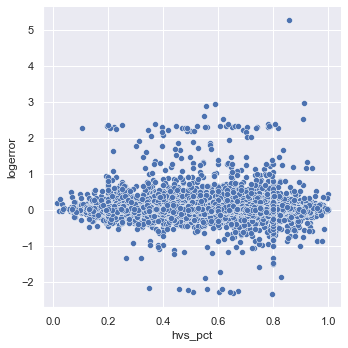

In [255]:

sns.relplot(x=train.hvs_pct, y=df.logerror, data=train, palette='deep', legend='auto', kind='scatter', height=5, aspect=1, facet_kws=None, units=None, )

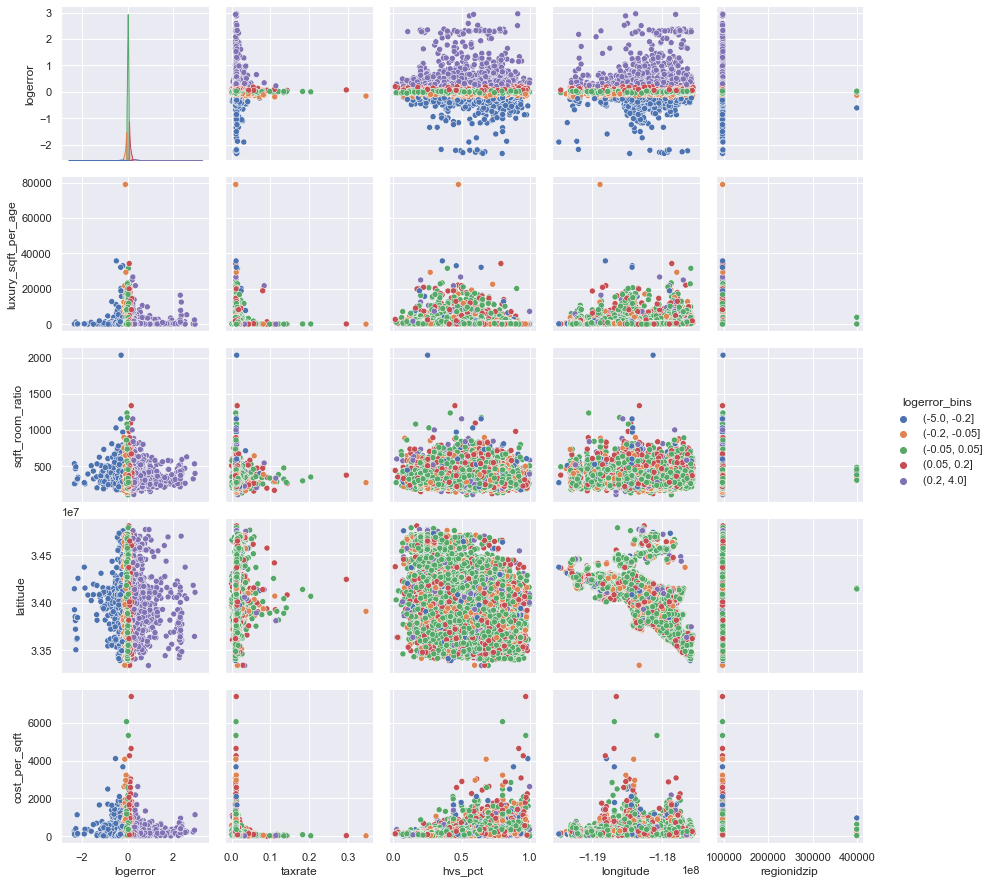

In [239]:
sns.pairplot(data = train, hue = 'logerror_bins', 
             x_vars = ['logerror', 'taxrate', 'hvs_pct', 'longitude', 
                       'regionidzip'],
             y_vars = ['logerror', 'luxury_sqft_per_age', 'sqft_room_ratio', 'latitude', 'cost_per_sqft'])

    1. log error and tax rate are correllated, lower has greater error
    2. log error and hvs pct have an interesting chart
    3. lower log error towards the southern and northern latitudes
    4. plot of lat long is awesome, la area map!
    5. luxurysqft/age related to logerror

In [236]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52119 entries, 0 to 52318
Data columns (total 35 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   parcelid                             52119 non-null  int64  
 1   bathrooms                            52119 non-null  int32  
 2   bedrooms                             52119 non-null  int32  
 3   sqft                                 52119 non-null  int32  
 4   fips                                 52119 non-null  object 
 5   fullbathcnt                          52119 non-null  float64
 6   garagecarcnt                         52119 non-null  int32  
 7   latitude                             52119 non-null  float64
 8   longitude                            52119 non-null  float64
 9   lotsizesquarefeet                    52119 non-null  float64
 10  poolcnt                              52119 non-null  int32  
 11  regionidcity                

In [ ]:
df["home_value_structure_tax_difference"] = df["home_value_structure_tax_difference"].astype(str)
df["taxamount"] = df["taxamount"].astype(int)
df["landtaxvaluedollarcnt"] = df["landtaxvaluedollarcnt"].astype(int)
df["structuretaxvaluedollarcnt"] = df["structuretaxvaluedollarcnt"].astype(int)
df["regionidzip"] = df["regionidzip"].astype(int)
df["lotsizesquarefeet"] = df["lotsizesquarefeet"].astype(int)

KeyboardInterrupt: 

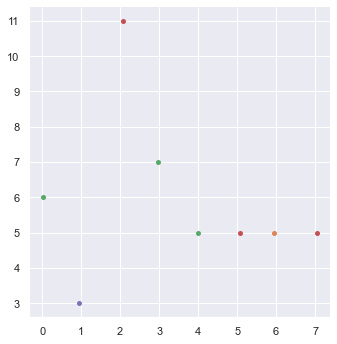

In [777]:
sns.catplot(x="sqft_room_ratio", y="luxury_score", hue='logerror_bins', data=train)

In [246]:
df.cost_per_sqft.astype(int).describe()

count              52,119.00
mean                  259.69
std                   221.91
min                     0.00
25%                   123.00
50%                   226.00
75%                   333.00
max                 7,382.00
Name: cost_per_sqft, dtype: float64

KeyboardInterrupt: 

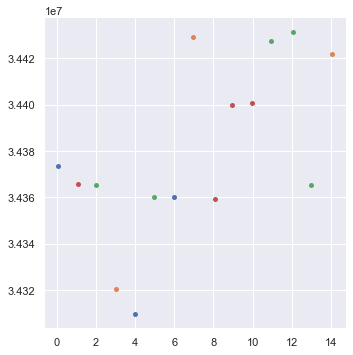

In [310]:
sns.catplot(x="longitude", y="latitude", hue='logerror_bins', data=train)

In [ ]:
sns.catplot(x="luxury_score", y="sqft_room_ratio", hue='logerror_bins', data=train)


KeyboardInterrupt



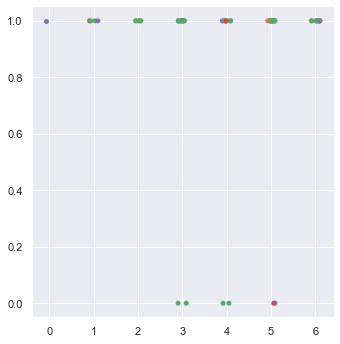

In [238]:
sns.catplot(x="luxury_sqft_per_age", y="LA", hue='logerror_bins', data=train)

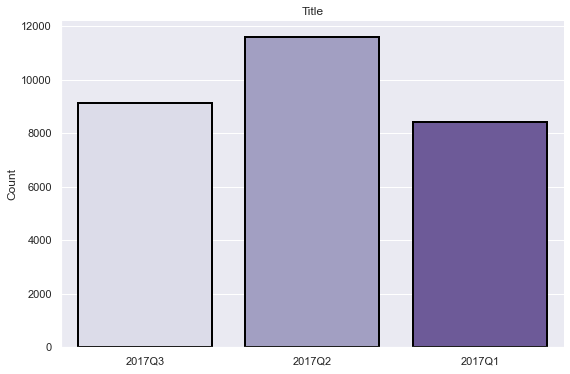

In [778]:
sns.countplot(x = 'quarter', data=train, palette='Purples', ec='black', linewidth=2)

plt.title('Title')
plt.xlabel('')
plt.ylabel('Count')

plt.show()

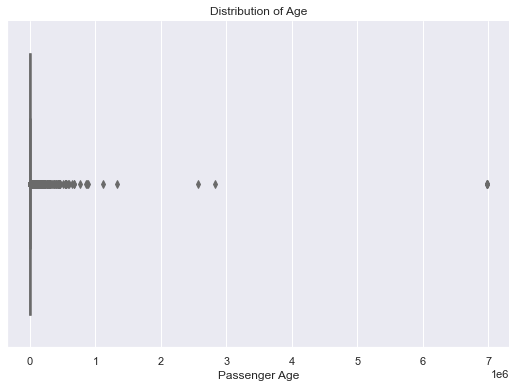

In [779]:
sns.boxplot(x=train.lotsizesquarefeet, palette='Purples')

plt.title('Distribution of Age')
plt.xlabel('Passenger Age')

plt.show()

Question 1

Is log error significantly different for properties in the three counties?

Null hypothesis: Log error will be the same across all three counties.
Alternative hypothesis: Log error will vary based on county.

five questions
1. more error based on location? county? coast? lat/long? fips?
2. error related to cost?
3. error related to lot size?
4. error related to age?
5. error related transaction date? seasonal?
6. error related to luxury items, garage, pool, airconditioning?
7. error related to tax/value/structure/land?

### Question

Is log error significantly different for properties based on time of year transaction occurred?

### Ho: Log error will be the same across all quarters observed.

### Ha: Log error will vary based quarter observed.

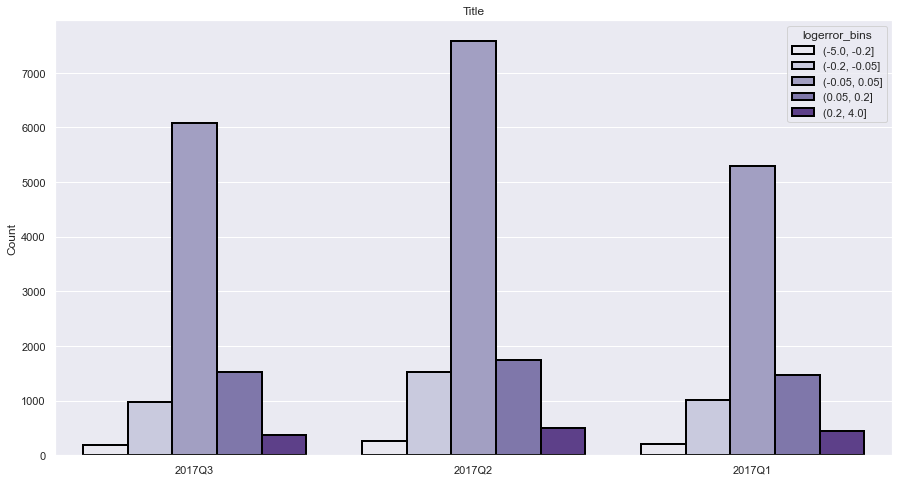

In [253]:
plt.figure(figsize=(15,8))
sns.countplot(x = 'quarter', hue='logerror_bins', data=train, palette='Purples', ec='black', linewidth=2)

plt.title('Title')
plt.xlabel('')
plt.ylabel('Count')

plt.show()

1. looks like the distribution of log error is the same for all quarters examined


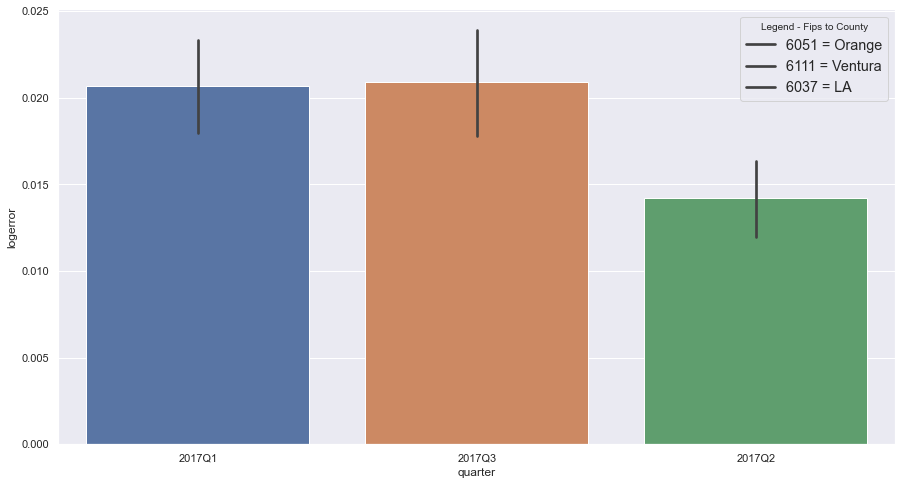

In [275]:
#Compare the average log error between counties
plt.figure(figsize=(15,8))
sns.barplot(x='quarter', y='logerror', data=df)
plt.legend(labels=["6051 = Orange","6111 = Ventura","6037 = LA"], title = "Legend - Fips to County", 
           fontsize = 'large', title_fontsize = "10")

In [276]:
#Set the value of alpha for statistical tests
alpha = 0.05

In [280]:
#Conduct an ANOVA test between the counties
f_quarters, p_quarters = stats.f_oneway(df[df['quarter'] == '2017Q1'].logerror,
                                    df[df['quarter'] == '2017Q2'].logerror,
                                    df[df['quarter'] == '2017Q3'].logerror)

f_quarters, p_quarters

(8.684565159303844, 0.00016942193591192096)

In [281]:
#Compare my p value to alpha
if p_quarters < alpha:
    print('We reject the null hypothesis.')
else:
    print('We fail to reject the null hypothesis.')

We reject the null hypothesis.


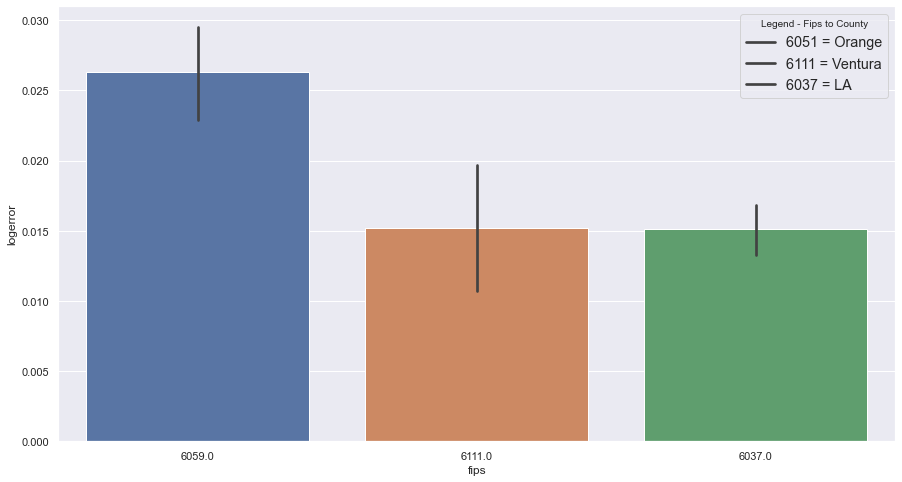

In [264]:
#Compare the average log error between counties
plt.figure(figsize=(15,8))
sns.barplot(x='fips', y='logerror', data=df)
plt.legend(labels=["6051 = Orange","6111 = Ventura","6037 = LA"], title = "Legend - Fips to County", 
           fontsize = 'large', title_fontsize = "10")

### Question

Is log error significantly different for properties in the three counties?

### Ho: Log error will be the same across all three counties.

### Ha: Log error will vary based on county.

In [270]:
#Set the value of alpha for statistical tests
alpha = 0.05

In [268]:
#Conduct an ANOVA test between the counties
f_county, p_county = stats.f_oneway(df[df['fips'] == '6037.0'].logerror,
                                    df[df['fips'] == '6059.0'].logerror,
                                    df[df['fips'] == '6111.0'].logerror)

f_county, p_county

(20.800505196742723, 9.333809168128782e-10)

In [271]:
#Compare my p value to alpha
if p_county < alpha:
    print('We reject the null hypothesis.')
else:
    print('We fail to reject the null hypothesis.')

We reject the null hypothesis.


### Question

Is Is there a correlation between the tax rate and its log error?

### Ho: There is no correlation between tax rate and log error..

### Ha: There is a relationship between tax rate and log error.

<AxesSubplot:xlabel='taxrate', ylabel='logerror'>

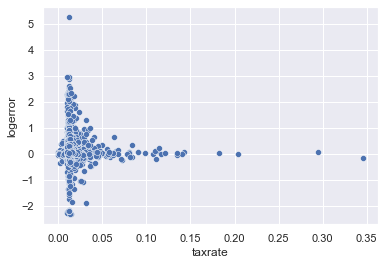

In [282]:
#Scatterplot of logerror as a function of home price
sns.scatterplot(x='taxrate', y='logerror', data=train)

In [294]:
#Set the value of alpha for statistical tests
alpha = 0.05

In [295]:
#Test for correlation between the two
corr_value, p_value = stats.pearsonr(df['taxrate'],
                                     df['logerror'])

corr_value, p_value

(0.006594427439788388, 0.1322056611502939)

In [296]:
#Test my hypothesis
if p_value < alpha:
    print('We reject the null hypothesis.')
else:
    print('We fail to reject the null hypothesis. There is a relationship between tax rate and log error')

We fail to reject the null hypothesis. There is a relationship between tax rate and log error


### Question

Is Is there a correlation between the home's longitude and its log error?

### Ho: There is no correlation between longitude and log error..

### Ha: There is a relationship between longitude and log error.

<AxesSubplot:xlabel='longitude', ylabel='logerror'>

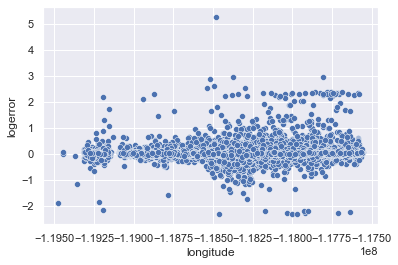

In [287]:
#Scatterplot of logerror as a function of home price
sns.scatterplot(x='longitude', y='logerror', data=train)

In [297]:
#Set the value of alpha for statistical tests
alpha = 0.05

In [298]:
#Test for correlation between the two
corr_value, p_value = stats.pearsonr(df['longitude'],
                                     df['logerror'])

corr_value, p_value

(0.02516860095267509, 9.102358174567858e-09)

In [300]:
#Test my hypothesis
if p_value < alpha:
    print('We reject the null hypothesis. Strong relationship between longitude and logerror')
else:
    print('We fail to reject the null hypothesis.')

We reject the null hypothesis. Strong relationship between longitude and logerror


### Question

Is Is there a correlation between the home's cost per sqft and its log error?

### Ho: There is no correlation between cost per sqft and log error..

### Ha: There is a relationship between cost per sqft and log error.

<AxesSubplot:xlabel='cost_per_sqft', ylabel='logerror'>

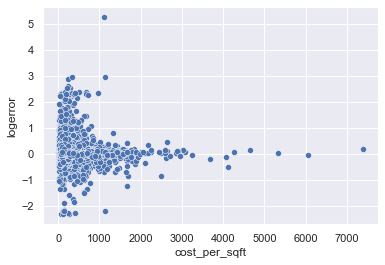

In [301]:
#Scatterplot of logerror as a function of home price
sns.scatterplot(x='cost_per_sqft', y='logerror', data=train)

In [302]:
#Set the value of alpha for statistical tests
alpha = 0.05

In [303]:
#Test for correlation between the two
corr_value, p_value = stats.pearsonr(df['cost_per_sqft'],
                                     df['logerror'])

corr_value, p_value

(-0.037917525327933174, 4.745858214414896e-18)

In [305]:
#Test my hypothesis
if p_value < alpha:
    print('We reject the null hypothesis. Strong relationship between longitude and logerror.')
else:
    print('We fail to reject the null hypothesis.')

We reject the null hypothesis. Strong relationship between longitude and logerror.


### Question

Is Is there a correlation between the home's luxury_sqft_per_age and its log error?

### Ho: There is no correlation between luxury_sqft_per_age and log error..

### Ha: There is a relationship between luxury_sqft_per_age and log error.

<AxesSubplot:xlabel='luxury_sqft_per_age', ylabel='logerror'>

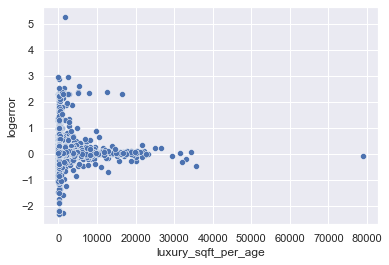

In [306]:
#Scatterplot of logerror as a function of home price
sns.scatterplot(x='luxury_sqft_per_age', y='logerror', data=train)

In [307]:
#Set the value of alpha for statistical tests
alpha = 0.05

In [308]:
#Test for correlation between the two
corr_value, p_value = stats.pearsonr(df['cost_per_sqft'],
                                     df['logerror'])

corr_value, p_value

(-0.037917525327933174, 4.745858214414896e-18)

In [309]:
#Test my hypothesis
if p_value < alpha:
    print('We reject the null hypothesis. Strong relationship between longitude and logerror.')
else:
    print('We fail to reject the null hypothesis.')

We reject the null hypothesis. Strong relationship between longitude and logerror.


## Key Takeaways/Summary of stats tests

    1.
    2.
    3.
    4.
    5.
    6.
    7.
    8.
   

Scale

I will scale all of our features using MinMaxScaler

In [363]:
X_train.shape,X_validate.shape,X_test.shape

((29186, 34), (12509, 34), (10424, 34))

In [364]:
X_train = X_train.drop(columns=['parcelid', 'fips', 'fullbathcnt', 'regionidcity', 'regionidzip', 'yearbuilt', 'transactiondate',
 'airconditioningdesc', 'heatingorsystemdesc', 'quarter'])
X_validate = X_validate.drop(columns=['parcelid', 'fips', 'fullbathcnt', 'regionidcity', 'regionidzip', 'yearbuilt', 'transactiondate',
 'airconditioningdesc', 'heatingorsystemdesc', 'quarter'])
X_test = X_test.drop(columns=['parcelid', 'fips', 'fullbathcnt', 'regionidcity', 'regionidzip', 'yearbuilt', 'transactiondate',
 'airconditioningdesc', 'heatingorsystemdesc', 'quarter'])

In [370]:
#Assign the scaler to a variable, and fit/transform the training data
mms = sklearn.preprocessing.MinMaxScaler()

mms.fit(X_train)

train_scaled = mms.transform(X_train)
train_scaled = pd.DataFrame(train_scaled, columns=X_train.columns, index=X_train.index)

validate_scaled = mms.transform(X_validate)
validate_scaled = pd.DataFrame(validate_scaled, columns=X_validate.columns, index=X_validate.index)

test_scaled = mms.transform(X_test)
test_scaled = pd.DataFrame(test_scaled, columns=X_test.columns, index=X_test.index)

In [369]:
train_scaled

,bathrooms,bedrooms,sqft,garagecarcnt,latitude,longitude,lotsizesquarefeet,poolcnt,structuretaxvaluedollarcnt,home_value,...,taxrate,age,cost_per_sqft,sqft_room_ratio,airconditioning_encoded,luxury_score,luxury_sqft_per_age,LA,Orange,Ventura
46517,0.17,0.31,0.12,0.00,0.39,0.66,0.00,0.00,0.01,0.00,...,0.06,0.53,0.01,0.14,0.00,0.18,0.00,1.00,0.00,0.00
33318,0.11,0.15,0.04,0.00,0.38,0.76,0.00,1.00,0.01,0.01,...,0.04,0.47,0.04,0.07,0.00,0.12,0.00,1.00,0.00,0.00
29240,0.06,0.15,0.03,0.00,0.66,0.55,0.00,0.00,0.00,0.00,...,0.04,0.53,0.01,0.07,0.00,0.06,0.00,1.00,0.00,0.00
731,0.11,0.15,0.06,0.14,0.37,0.80,0.00,0.00,0.01,0.00,...,0.04,0.43,0.01,0.12,0.00,0.15,0.00,0.00,1.00,0.00
8822,0.11,0.15,0.08,0.14,0.22,0.77,0.00,0.00,0.04,0.01,...,0.03,0.21,0.03,0.14,0.00,0.15,0.01,0.00,1.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24562,0.11,0.08,0.04,0.00,0.57,0.62,0.00,0.00,0.01,0.01,...,0.03,0.57,0.06,0.11,0.00,0.06,0.00,1.00,0.00,0.00
31130,0.22,0.31,0.15,0.14,0.19,0.99,0.00,1.00,0.05,0.02,...,0.03,0.16,0.03,0.14,0.00,0.30,0.02,0.00,1.00,0.00
9334,0.11,0.23,0.08,0.14,0.14,0.95,0.00,0.00,0.04,0.01,...,0.05,0.10,0.03,0.12,0.00,0.18,0.02,0.00,1.00,0.00
10383,0.06,0.23,0.05,0.00,0.46,0.82,0.00,0.00,0.01,0.00,...,0.04,0.44,0.01,0.09,0.00,0.09,0.00,1.00,0.00,0.00


In [379]:
# from sklearn.feature_selection import SelectKBest, f_regression

# parameters: f_regression stats test, give me 4 features
f_selector = SelectKBest(f_regression, k=8)

# find the top 8 X's correlated with y
f_selector.fit(X_train, y_train)

# boolean mask of whether the column was selected or not. 
feature_mask = f_selector.get_support()

# get list of top K features. 
f_feature = X_train.iloc[:,feature_mask].columns.tolist()

In [380]:
f_feature

['bathrooms',
 'bedrooms',
 'sqft',
 'garagecarcnt',
 'age',
 'luxury_score',
 'luxury_sqft_per_age',
 'Orange']

In [381]:
# initialize the ML algorithm
lm = LinearRegression()

# create the rfe object, indicating the ML object (lm) and the number of features I want to end up with. 
rfe = RFE(lm, n_features_to_select=8)

# fit the data using RFE
rfe.fit(X_train,y_train)  

# get the mask of the columns selected
feature_mask = rfe.support_

# get list of the column names. 
rfe_feature = X_train.iloc[:,feature_mask].columns.tolist()

In [382]:
rfe_feature

['bedrooms',
 'garagecarcnt',
 'poolcnt',
 'airconditioning_encoded',
 'luxury_score',
 'LA',
 'Orange',
 'Ventura']

In [691]:
train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29186 entries, 46517 to 49102
Data columns (total 32 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   bathrooms                            29186 non-null  float64
 1   bedrooms                             29186 non-null  float64
 2   sqft                                 29186 non-null  float64
 3   garagecarcnt                         29186 non-null  float64
 4   latitude                             29186 non-null  float64
 5   longitude                            29186 non-null  float64
 6   lotsizesquarefeet                    29186 non-null  float64
 7   poolcnt                              29186 non-null  float64
 8   structuretaxvaluedollarcnt           29186 non-null  float64
 9   home_value                           29186 non-null  float64
 10  landtaxvaluedollarcnt                29186 non-null  float64
 11  taxamount               

In [427]:
#Fill a list with inertia values for increasing number of clusters
inertia_list = []

for i in range(2, 8):
    kmeans_scaled = KMeans(n_clusters=i)
    kmeans_scaled.fit(train_scaled)
    inertia_list.append(kmeans_scaled.inertia_)
    
inertia_list  

[34562.550262713565,
 19228.998304466062,
 10969.32565714353,
 6051.914047701046,
 4618.385076133708,
 3611.568350792479]

Text(0.5, 0, 'Number of clusters')

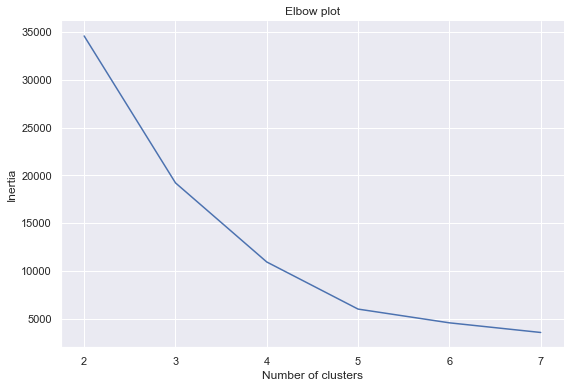

In [428]:
#Beautiful elbow graph
sns.lineplot(x=range(2, 8), y=inertia_list)
plt.title('Elbow plot')
plt.ylabel('Inertia')
plt.xlabel('Number of clusters')

looks like k = 5 is the best 

In [684]:
#Create a new X subset with 3 features
X2_train = train_scaled[['luxury_sqft_per_age', 'longitude', 'home_value']]
X2_validate = validate_scaled[['luxury_sqft_per_age', 'longitude', 'home_value']]
X2_test = test_scaled[['luxury_sqft_per_age', 'longitude', 'home_value']]

In [685]:
#Fit a KMeans model to my 3 feature dataset
kmeans2 = KMeans(n_clusters=3)

kmeans2.fit(X2_train)

kmeans2.predict(X2_train)

array([0, 1, 0, ..., 1, 1, 0])

In [686]:
#Store my predictions in the dataframe
train_scaled['expensive coastal'] = kmeans2.predict(X2_train)
validate_scaled['expensive coastal'] = kmeans2.predict(X2_validate)
test_scaled['expensive coastal'] = kmeans2.predict(X2_test)

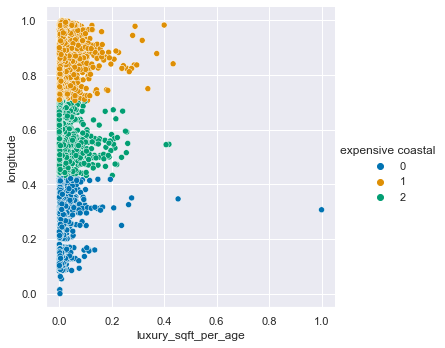

In [432]:
#Visualize my results
sns.relplot(x='luxury_sqft_per_age', y='longitude', hue='expensive coastal',
            palette='colorblind', data=train_scaled)

In [434]:
#Create a list of inertias for models fit to my 3 features
expensive_coastal = []

for i in range(2, 8):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X2_train)
    expensive_coastal.append(kmeans.inertia_)
    
expensive_coastal 

[381.7998074528004,
 194.2171165772219,
 110.14085254602819,
 82.07568827540871,
 61.799889571956584,
 48.09868878126192]

Text(0.5, 0, 'Number of clusters')

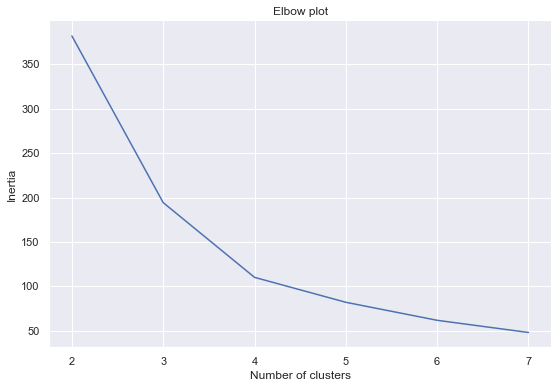

In [436]:
#Plot the inertia over number of clusters
sns.lineplot(x=range(2, 8), y=expensive_coastal)
plt.title('Elbow plot')
plt.ylabel('Inertia')
plt.xlabel('Number of clusters')

looks like 4 is the best for those three features

In [681]:
#Create a new X subset with far from beach, orange and ventura counties,
X7_train = train_scaled[['longitude', 'Orange', 'Ventura','luxury_sqft_per_age','luxury_score']]
X7_validate = validate_scaled[['longitude', 'Orange', 'Ventura','luxury_sqft_per_age','luxury_score']]
X7_test = test_scaled[['longitude', 'Orange', 'Ventura','luxury_sqft_per_age','luxury_score']]


In [682]:
#Fit a KMeans model to my 3 feature dataset
kmeans7 = KMeans(n_clusters=3)

kmeans7.fit(X7_train)

kmeans7.predict(X7_train)

array([0, 0, 0, ..., 1, 0, 0])

In [683]:
#Store my predictions in the dataframe
train_scaled['NotLAluxury'] = kmeans7.predict(X7_train)
validate_scaled['NotLAluxury'] = kmeans7.predict(X7_validate)
test_scaled['NotLAluxury'] = kmeans7.predict(X7_test)

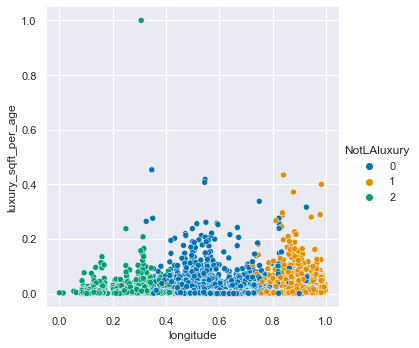

In [546]:
#Visualize my results
sns.relplot(x='longitude', y='luxury_sqft_per_age', hue='NotLAluxury',
            palette='colorblind', data=train_scaled)

In [547]:
#Create a list of inertias for models fit to my 3 features
NotLAluxury = []

for i in range(2, 8):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X7_train)
    NotLAluxury.append(kmeans.inertia_)
    
NotLAluxury 

[2932.6692168676673,
 470.85998019703226,
 305.17307919717484,
 246.89252592938834,
 215.7961063183326,
 187.55669466047803]

Text(0.5, 0, 'Number of clusters')

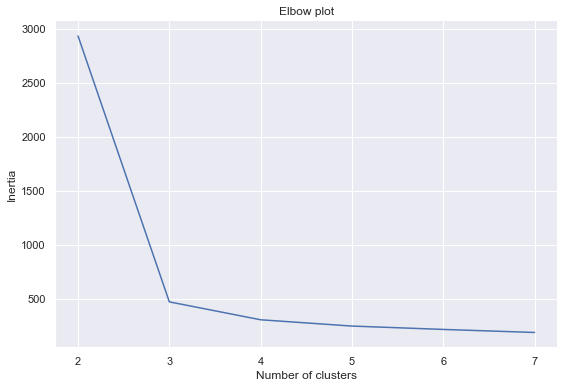

In [548]:
#Plot the inertia over number of clusters
sns.lineplot(x=range(2, 8), y=NotLAluxury)
plt.title('Elbow plot')
plt.ylabel('Inertia')
plt.xlabel('Number of clusters')

k of three for not la and luxury score

In [678]:
#Create a new X subset with 3 features
X3_train = train_scaled[['sqft_room_ratio', 'cost_per_sqft', 'age','home_value']]
X3_validate = validate_scaled[['sqft_room_ratio', 'cost_per_sqft', 'age','home_value']]
X3_test= test_scaled[['sqft_room_ratio', 'cost_per_sqft', 'age','home_value']]

In [679]:
#Fit a KMeans model to my 3 feature dataset
kmeans3 = KMeans(n_clusters=3)

kmeans3.fit(X3_train)

kmeans3.predict(X3_train)

array([0, 0, 0, ..., 1, 0, 2])

In [680]:
#Store my predictions in the dataframe
train_scaled['squarefootage_cost_homevalue'] = kmeans3.predict(X3_train)
validate_scaled['squarefootage_cost_homevalue'] = kmeans3.predict(X3_validate)
test_scaled['squarefootage_cost_homevalue'] = kmeans3.predict(X3_test)

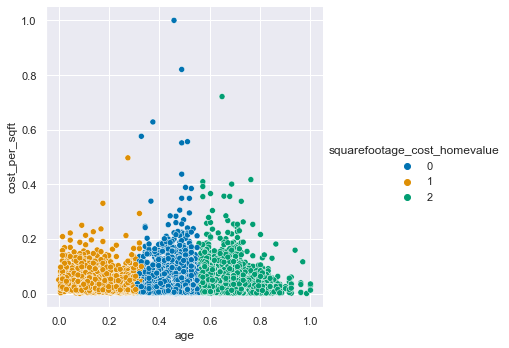

In [444]:
#Visualize my results
sns.relplot(x='age', y='cost_per_sqft', hue='squarefootage_cost_homevalue',
            palette='colorblind', data=train_scaled)

In [510]:
#Create a list of inertias for models fit to my 3 features
squarefootage_cost_homevalue = []

for i in range(2, 8):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X3_train)
    squarefootage_cost_homevalue.append(kmeans.inertia_)
    
squarefootage_cost_homevalue 

[399.8937395233452,
 229.61553407161202,
 167.65191971404056,
 139.90997840408266,
 124.26602507664569,
 113.22371447178162]

Text(0.5, 0, 'Number of clusters')

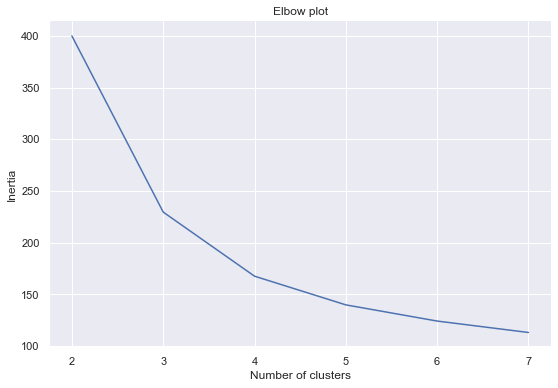

In [511]:
#Plot the inertia over number of clusters
sns.lineplot(x=range(2, 8), y=squarefootage_cost_homevalue)
plt.title('Elbow plot')
plt.ylabel('Inertia')
plt.xlabel('Number of clusters')

looks like 3 is best k for squarefootage_cost_homevalue cluster

In [675]:
#Create a new X subset with location based features
X4_train = train_scaled[['latitude', 'longitude', 'luxury_sqft_per_age','taxrate']]
X4_validate= validate_scaled[['latitude', 'longitude', 'luxury_sqft_per_age','taxrate']]
X4_test= test_scaled[['latitude', 'longitude', 'luxury_sqft_per_age','taxrate']]

In [676]:
#Fit a KMeans model to my 4 feature dataset
kmeans4 = KMeans(n_clusters=4)

kmeans4.fit(X4_train)

kmeans4.predict(X4_train)

array([3, 3, 2, ..., 1, 3, 3])

In [677]:
#Store my predictions in the dataframe
train_scaled['latlongluxurytax'] = kmeans4.predict(X4_train)
validate_scaled['latlongluxurytax'] = kmeans4.predict(X4_validate)
test_scaled['latlongluxurytax'] = kmeans4.predict(X4_test)

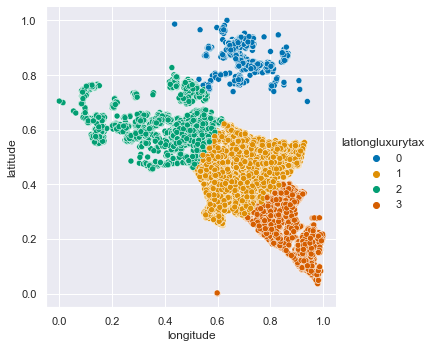

In [464]:
#Visualize my results
sns.relplot(x='longitude', y='latitude', hue='latlongluxurytax',
            palette='colorblind', data=train_scaled)

In [501]:
#Create a list of inertias for models fit to ffeatures
latlongluxurytax = []

for i in range(2, 8):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X4_train)
    latlongluxurytax.append(kmeans.inertia_)
    
latlongluxurytax

[959.2441169905882,
 707.9667282566261,
 475.3362875578192,
 354.711412038423,
 271.52914482328066,
 218.13675012402425]

Text(0.5, 0, 'Number of clusters')

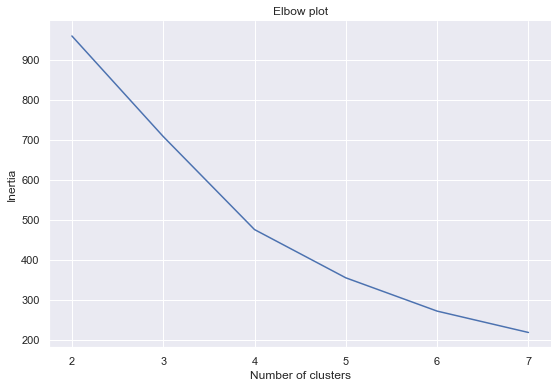

In [502]:
#Plot the inertia over number of clusters
sns.lineplot(x=range(2, 8), y=latlongluxurytax)
plt.title('Elbow plot')
plt.ylabel('Inertia')
plt.xlabel('Number of clusters')

k of 4 for latlongluxurytaxrate

In [672]:
#Create a new X subset with features from f feature
X5_train = train_scaled[['luxury_score', 'age', 'sqft','bedrooms']]
X5_validate= validate_scaled[['luxury_score', 'age', 'sqft','bedrooms']]
X5_test= test_scaled[['luxury_score', 'age', 'sqft','bedrooms']]


In [673]:
#Fit a KMeans model to my 4 feature dataset
kmeans5 = KMeans(n_clusters=3)

kmeans5.fit(X5_train)

kmeans5.predict(X5_train)

array([0, 0, 2, ..., 1, 0, 2])

In [674]:
#Store my predictions in the dataframe
train_scaled['ffeatures'] = kmeans5.predict(X5_train)

validate_scaled['ffeatures'] = kmeans5.predict(X5_validate)
test_scaled['ffeatures'] = kmeans5.predict(X5_test)

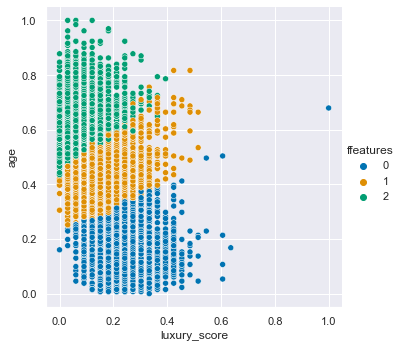

In [473]:
#Visualize my results
sns.relplot(x='luxury_score', y='age', hue='ffeatures',
            palette='colorblind', data=train_scaled)

In [503]:
#Create a list of inertias for models fit to ffeatures
ffeatures = []

for i in range(2, 8):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X5_train)
    ffeatures.append(kmeans.inertia_)
    
ffeatures

[13493.172773361159,
 9037.73202090329,
 5333.684976056685,
 3342.087413739428,
 1914.34126056432,
 950.7329721346636]

Text(0.5, 0, 'Number of clusters')

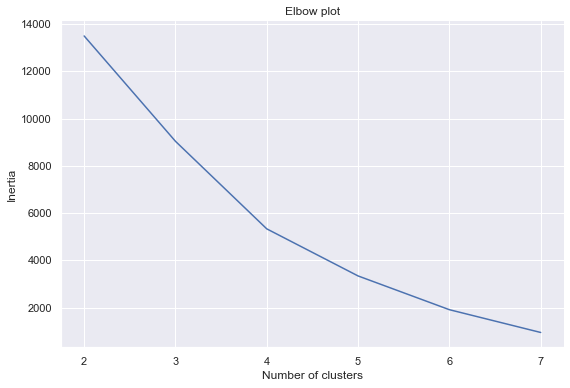

In [508]:
#Plot the inertia over number of clusters
sns.lineplot(x=range(2, 8), y=ffeatures)
plt.title('Elbow plot')
plt.ylabel('Inertia')
plt.xlabel('Number of clusters')

k of 4 looks best for ffeatures cluster

In [629]:
train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29186 entries, 46517 to 49102
Data columns (total 31 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   bathrooms                            29186 non-null  float64
 1   bedrooms                             29186 non-null  float64
 2   sqft                                 29186 non-null  float64
 3   garagecarcnt                         29186 non-null  float64
 4   latitude                             29186 non-null  float64
 5   longitude                            29186 non-null  float64
 6   lotsizesquarefeet                    29186 non-null  float64
 7   poolcnt                              29186 non-null  float64
 8   structuretaxvaluedollarcnt           29186 non-null  float64
 9   home_value                           29186 non-null  float64
 10  landtaxvaluedollarcnt                29186 non-null  float64
 11  taxamount               

In [ ]:
['luxury_sqft_per_age','luxury_score ','sqft_room_ratio','cost_per_sqft','age','taxrate','hvs_pct','home_value_structure_tax_difference','','','','','','','','','',''

In [668]:
#Create a new X subset with features from rfefeatures
X6_train = train_scaled[['luxury_sqft_per_age','luxury_score',
                         'sqft_room_ratio','cost_per_sqft','age',
                         'taxrate','hvs_pct','home_value_structure_tax_difference']]


In [669]:
#ensuring the cluster is added to the validate and test sets as well

X6_validate= validate_scaled[['luxury_sqft_per_age','luxury_score',
                         'sqft_room_ratio','cost_per_sqft','age',
                         'taxrate','hvs_pct','home_value_structure_tax_difference']]
X6_test = test_scaled[['luxury_sqft_per_age','luxury_score',
                         'sqft_room_ratio','cost_per_sqft','age',
                         'taxrate','hvs_pct','home_value_structure_tax_difference']]

In [670]:
#Fit a KMeans model to my 4 feature dataset
kmeans6 = KMeans(n_clusters=4)

kmeans6.fit(X6_train)

kmeans6.predict(X6_train)

array([0, 2, 0, ..., 3, 0, 2])

In [671]:
#Store my predictions in the dataframe
train_scaled['rfefeatures'] = kmeans6.predict(X6_train)
validate_scaled['rfefeatures'] = kmeans6.predict(X6_validate)
test_scaled['rfefeatures'] = kmeans6.predict(X6_test)

In [667]:
#Store my predictions in the dataframe
validate_scaled['rfefeatures'] = kmeans6.predict(X6_validate)
test_scaled['rfefeatures'] = kmeans6.predict(X6_test)

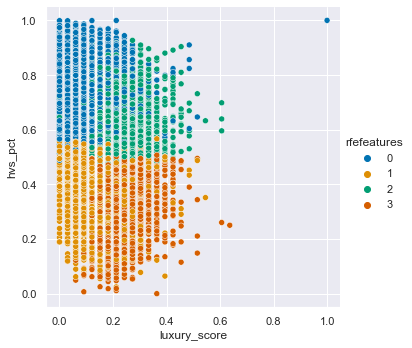

In [655]:
#Visualize my results
sns.relplot(x='luxury_score', y='hvs_pct', hue='rfefeatures',
            palette='colorblind', data=train_scaled)

In [642]:
#Create a list of inertias for models fit to rfefeatures
rfefeatures = []

for i in range(2, 8):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X6_train)
    rfefeatures.append(kmeans.inertia_)
    
rfefeatures

[1329.764613106644,
 1007.3672875331235,
 800.2499312722126,
 667.0360357745317,
 584.1969163890958,
 534.405222951504]

Text(0.5, 0, 'Number of clusters')

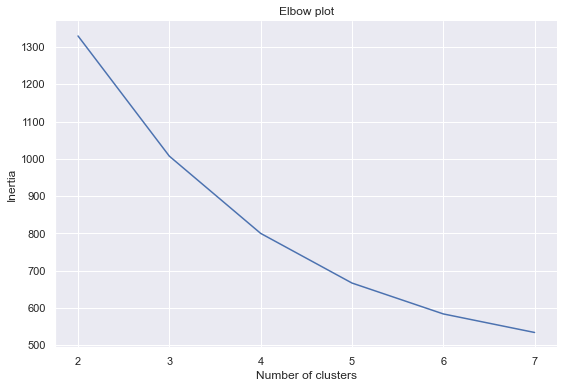

In [643]:
#Plot the inertia over number of clusters
sns.lineplot(x=range(2, 8), y=rfefeatures)
plt.title('Elbow plot')
plt.ylabel('Inertia')
plt.xlabel('Number of clusters')

k of four for rfefeatures cluster

In [693]:
train_scaled.head()

,bathrooms,bedrooms,sqft,garagecarcnt,latitude,longitude,lotsizesquarefeet,poolcnt,structuretaxvaluedollarcnt,home_value,...,Orange,Ventura,cluster,expensive coastal,squarefootage_cost_homevalue,latlongluxurytax,ffeatures,rfefeatures,NotLAluxury,all data cluster
46517,0.17,0.31,0.12,0.00,0.39,0.66,0.00,0.00,0.01,0.00,...,0.00,0.00,1,0,0,3,0,0,0,2
33318,0.11,0.15,0.04,0.00,0.38,0.76,0.00,1.00,0.01,0.01,...,0.00,0.00,2,1,0,3,0,2,0,2
29240,0.06,0.15,0.03,0.00,0.66,0.55,0.00,0.00,0.00,0.00,...,0.00,0.00,1,0,0,2,2,0,0,0
731,0.11,0.15,0.06,0.14,0.37,0.80,0.00,0.00,0.01,0.00,...,1.00,0.00,0,1,0,1,0,0,1,1
8822,0.11,0.15,0.08,0.14,0.22,0.77,0.00,0.00,0.04,0.01,...,1.00,0.00,0,1,1,1,1,3,1,1


In [692]:
validate_scaled

,bathrooms,bedrooms,sqft,garagecarcnt,latitude,longitude,lotsizesquarefeet,poolcnt,structuretaxvaluedollarcnt,home_value,...,luxury_sqft_per_age,LA,Orange,Ventura,rfefeatures,ffeatures,latlongluxurytax,squarefootage_cost_homevalue,NotLAluxury,expensive coastal
19941,0.11,0.15,0.15,0.14,0.28,0.88,0.00,1.00,0.02,0.02,...,0.01,0.00,1.00,0.00,2,0,1,0,1,1
51919,0.06,0.08,0.03,0.00,0.37,0.68,0.00,0.00,0.01,0.00,...,0.00,1.00,0.00,0.00,2,2,3,0,0,0
30001,0.17,0.23,0.12,0.00,0.91,0.71,0.00,0.00,0.02,0.00,...,0.03,1.00,0.00,0.00,3,1,0,1,0,1
17460,0.11,0.23,0.08,0.14,0.38,0.84,0.00,0.00,0.01,0.00,...,0.00,0.00,1.00,0.00,0,0,1,0,1,1
14055,0.11,0.23,0.07,0.00,0.29,0.76,0.00,0.00,0.00,0.00,...,0.00,0.00,1.00,0.00,0,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5629,0.11,0.15,0.06,0.14,0.10,0.93,0.00,0.00,0.01,0.02,...,0.00,0.00,1.00,0.00,1,1,1,1,1,1
44245,0.11,0.15,0.05,0.00,0.42,0.67,0.00,0.00,0.01,0.01,...,0.00,1.00,0.00,0.00,1,0,3,1,0,0
8027,0.06,0.15,0.02,0.00,0.90,0.67,0.00,0.00,0.01,0.00,...,0.00,1.00,0.00,0.00,0,0,0,0,0,0
19410,0.17,0.23,0.16,0.14,0.06,0.98,0.00,1.00,0.05,0.01,...,0.02,0.00,1.00,0.00,3,1,1,1,1,1


In [705]:
train_scaled.drop(columns=['all data cluster'])

,bathrooms,bedrooms,sqft,garagecarcnt,latitude,longitude,lotsizesquarefeet,poolcnt,structuretaxvaluedollarcnt,home_value,...,LA,Orange,Ventura,cluster,expensive coastal,squarefootage_cost_homevalue,latlongluxurytax,ffeatures,rfefeatures,NotLAluxury
46517,0.17,0.31,0.12,0.00,0.39,0.66,0.00,0.00,0.01,0.00,...,1.00,0.00,0.00,1,0,0,3,0,0,0
33318,0.11,0.15,0.04,0.00,0.38,0.76,0.00,1.00,0.01,0.01,...,1.00,0.00,0.00,2,1,0,3,0,2,0
29240,0.06,0.15,0.03,0.00,0.66,0.55,0.00,0.00,0.00,0.00,...,1.00,0.00,0.00,1,0,0,2,2,0,0
731,0.11,0.15,0.06,0.14,0.37,0.80,0.00,0.00,0.01,0.00,...,0.00,1.00,0.00,0,1,0,1,0,0,1
8822,0.11,0.15,0.08,0.14,0.22,0.77,0.00,0.00,0.04,0.01,...,0.00,1.00,0.00,0,1,1,1,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24562,0.11,0.08,0.04,0.00,0.57,0.62,0.00,0.00,0.01,0.01,...,1.00,0.00,0.00,1,0,2,3,2,2,0
31130,0.22,0.31,0.15,0.14,0.19,0.99,0.00,1.00,0.05,0.02,...,0.00,1.00,0.00,0,1,1,1,1,3,1
9334,0.11,0.23,0.08,0.14,0.14,0.95,0.00,0.00,0.04,0.01,...,0.00,1.00,0.00,0,1,1,1,1,3,1
10383,0.06,0.23,0.05,0.00,0.46,0.82,0.00,0.00,0.01,0.00,...,1.00,0.00,0.00,1,1,0,3,0,0,0


In [706]:
train_scaled.shape, validate_scaled.shape, test_scaled.shape

((29186, 32), (12509, 30), (10424, 30))

### Drop unneeded columns, create dummy variables for any of the cluster features that I want to use

In [709]:
train_scaled.columns.values.tolist()

['bathrooms',
 'bedrooms',
 'sqft',
 'garagecarcnt',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'poolcnt',
 'structuretaxvaluedollarcnt',
 'home_value',
 'landtaxvaluedollarcnt',
 'taxamount',
 'home_value_structure_tax_difference',
 'hvs_pct',
 'taxrate',
 'age',
 'cost_per_sqft',
 'sqft_room_ratio',
 'airconditioning_encoded',
 'luxury_score',
 'luxury_sqft_per_age',
 'LA',
 'Orange',
 'Ventura',
 'cluster',
 'expensive coastal',
 'squarefootage_cost_homevalue',
 'latlongluxurytax',
 'ffeatures',
 'rfefeatures',
 'NotLAluxury',
 'all data cluster']

In [727]:
train_scaled = train_scaled.drop(columns=[
 'poolcnt',
 'landtaxvaluedollarcnt',
 'taxamount',
 'airconditioning_encoded',
 'LA',
 'Orange',
 'Ventura',
 'cluster',
 'squarefootage_cost_homevalue',
 'ffeatures',
 'rfefeatures',
 'NotLAluxury',
 'all data cluster'])

In [726]:
validate_scaled = validate_scaled.drop(columns=[
 'poolcnt',
 'landtaxvaluedollarcnt',
 'taxamount',
 'airconditioning_encoded',
 'LA',
 'Orange',
 'Ventura',
 'squarefootage_cost_homevalue',
 'ffeatures',
 'rfefeatures',
 'NotLAluxury',])

In [725]:
test_scaled = test_scaled.drop(columns=[
 'poolcnt',
 'landtaxvaluedollarcnt',
 'taxamount',
 'airconditioning_encoded',
 'LA',
 'Orange',
 'Ventura',
 'squarefootage_cost_homevalue',
 'ffeatures',
 'rfefeatures',
 'NotLAluxury',])

In [716]:
#dummy expensive coastal
dummies = pd.get_dummies(train_scaled['expensive coastal'])
train_scaled = pd.concat([train_scaled,dummies],axis=1)

In [717]:
dummies = pd.get_dummies(validate_scaled['expensive coastal'])
validate_scaled = pd.concat([validate_scaled,dummies],axis=1)

In [718]:
dummies = pd.get_dummies(test_scaled['expensive coastal'])
test_scaled = pd.concat([test_scaled,dummies],axis=1)

In [719]:
#dummy latlongluxurytax
dummies = pd.get_dummies(train_scaled['latlongluxurytax'])
train_scaled = pd.concat([train_scaled,dummies],axis=1)

In [720]:
dummies = pd.get_dummies(validate_scaled['latlongluxurytax'])
validate_scaled = pd.concat([validate_scaled,dummies],axis=1)

In [721]:
dummies = pd.get_dummies(test_scaled['latlongluxurytax'])
test_scaled = pd.concat([test_scaled,dummies],axis=1)

In [728]:
train_scaled.shape, validate_scaled.shape, test_scaled.shape

((29186, 26), (12509, 26), (10424, 26))

In [729]:
# from sklearn.feature_selection import SelectKBest, f_regression

# parameters: f_regression stats test, give me 3 features
f_selector = SelectKBest(f_regression, k=5)

# find the top 8 X's correlated with y
f_selector.fit(train_scaled, y_train.logerror)

# boolean mask of whether the column was selected or not. 
feature_mask = f_selector.get_support()

# get list of top K features. 
f_feature = train_scaled.iloc[:,feature_mask].columns.tolist()

In [730]:
f_feature

['bathrooms', 'bedrooms', 'sqft', 'luxury_score', 1]

In [731]:
# initialize the ML algorithm
lm = LinearRegression()

# create the rfe object, indicating the ML object (lm) and the number of features I want to end up with. 
rfe = RFE(lm, n_features_to_select=5)

# fit the data using RFE
rfe.fit(train_scaled,y_train.logerror)  

# get the mask of the columns selected
feature_mask = rfe.support_

# get list of the column names. 
rfe_feature = train_scaled.iloc[:,feature_mask].columns.tolist()

In [732]:
rfe_feature

['sqft',
 'structuretaxvaluedollarcnt',
 'home_value',
 'home_value_structure_tax_difference',
 'cost_per_sqft']

### Modeling

In [733]:
y_train.shape, y_validate.shape, y_test.shape

((29186, 3), (12509, 3), (10424, 3))

In [734]:
y_train.head()

,logerror,logerror_baseline_median,logerror_baseline_mean
46517,0.10,0.01,0.02
33318,-0.01,0.01,0.02
29240,0.03,0.01,0.02
731,0.02,0.01,0.02
8822,-0.14,0.01,0.02


Identify baseline

In [735]:
# 1. compute pred_median
logerror_baseline_median = y_train['logerror'].median()
y_train['logerror_baseline_median'] = logerror_baseline_median
y_validate['logerror_baseline_median'] = logerror_baseline_median
y_test['logerror_baseline_median'] = logerror_baseline_median

# 2. compute pred_mean
logerror_baseline_mean = y_train['logerror'].mean()
y_train['logerror_baseline_mean'] = logerror_baseline_mean
y_validate['logerror_baseline_mean'] = logerror_baseline_mean
y_test['logerror_baseline_mean'] = logerror_baseline_mean
#check to see which is better
y_train.head()

,logerror,logerror_baseline_median,logerror_baseline_mean
46517,0.10,0.01,0.02
33318,-0.01,0.01,0.02
29240,0.03,0.01,0.02
731,0.02,0.01,0.02
8822,-0.14,0.01,0.02


In [736]:
def plot_residuals(target, yhat):
    '''
    plot_residuals will take in a target series and prediction series
    and plot the residuals as a scatterplot.
    '''
    
    residual = target - yhat
    
    plt.scatter(target, residual)
    plt.axhline(y = 0, ls = ':')
    plt.xlabel("target")
    plt.ylabel("residual")
    plt.title('Residual Plot')
    plt.show

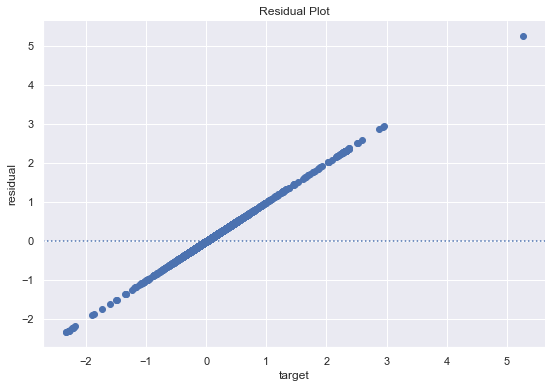

In [737]:
plot_residuals(y_train.logerror, logerror_baseline_median)

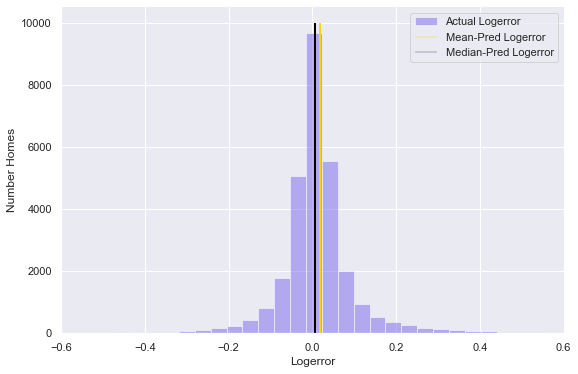

In [738]:
# plot to visualize actual vs predicted.
#median value performs better

plt.hist(y_train.logerror, bins=200, color='mediumslateblue', alpha=.5, label="Actual Logerror")
plt.vlines(y_train.logerror_baseline_mean, 0, 10000, color='gold', alpha=.3, label="Mean-Pred Logerror")
plt.vlines(y_train.logerror_baseline_median, 0,10000, color='black', alpha=.2, label="Median-Pred Logerror")
plt.xlim(-.6,.6)
plt.xlabel("Logerror")
plt.ylabel("Number Homes")
plt.legend()
plt.show()

median predicted logerror looks good for the baseline

In [776]:
# 3. RMSE of hv_pred_median
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_baseline_median) ** (0.5)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_baseline_median) ** (0.5)

print(f"""
      BASELINE:
      
      RMSE using Median
      Train/In-Sample: {round(rmse_train, 3)}
      Validate/Out-of-Sample: {round(rmse_validate, 3)}
        """)


      BASELINE:
      
      RMSE using Median
      Train/In-Sample: 0.174
      Validate/Out-of-Sample: 0.187
        


### Train / Validate
### Modeling: LinearRegression (OLS

In [740]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(train_scaled, y_train.logerror)

# predict train
y_train['logerror_pred_lm'] = lm.predict(train_scaled)

# evaluate: rmse
rmse_train_lm = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm)**(0.5)

# predict validate
y_validate['logerror_pred_lm'] = lm.predict(validate_scaled)

# evaluate: rmse
rmse_validate_lm = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm)**(0.5)

print(f"""
              BASELINE:
              
              RMSE using Median
              Train/In-Sample: {round(rmse_train, 2)}
              Validate/Out-of-Sample: {round(rmse_validate, 2)}

    RMSE for OLS using LinearRegression
    
    Training/In-Sample: {round(rmse_train_lm, 2)}
    Validation/Out-of-Sample: {round(rmse_validate_lm, 2)}
""")


              BASELINE:
              
              RMSE using Median
              Train/In-Sample: 0.17
              Validate/Out-of-Sample: 0.19

    RMSE for OLS using LinearRegression
    
    Training/In-Sample: 0.17
    Validation/Out-of-Sample: 1388204171058.12



### Modeling: LassoLars

In [742]:
# create the model object

lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(train_scaled, y_train.logerror)

# predict train
y_train['logerror_pred_lars'] = lars.predict(train_scaled)

# evaluate: rmse
rmse_train_lars = mean_squared_error(y_train.logerror, y_train.logerror_pred_lars)**(0.5)

# predict validate
y_validate['logerror_pred_lars'] = lars.predict(validate_scaled)

# evaluate: rmse
rmse_validate_lars = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lars)**(0.5)

print(f"""
              BASELINE:
              
              RMSE using Median
              Train/In-Sample: {round(rmse_train, 2)}
              Validate/Out-of-Sample: {round(rmse_validate, 2)}
              
                RMSE for OLS using LinearRegression
                
                Training/In-Sample: {round(rmse_train_lm, 2)}
                Validation/Out-of-Sample: {round(rmse_validate_lm, 2)}

    RMSE for LassoLars
    
    Training/In-Sample: {round(rmse_train_lars, 2)}
    Validation/Out-of-Sample: {round(rmse_validate_lars, 2)}
""")


              BASELINE:
              
              RMSE using Median
              Train/In-Sample: 0.17
              Validate/Out-of-Sample: 0.19
              
                RMSE for OLS using LinearRegression
                
                Training/In-Sample: 0.17
                Validation/Out-of-Sample: 1388204171058.12

    RMSE for LassoLars
    
    Training/In-Sample: 0.17
    Validation/Out-of-Sample: 0.19



### Modeling: TweedieRegressor (GLM)

In [775]:
# create the model object
glm = TweedieRegressor(power=0, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(train_scaled, y_train.logerror)

# predict train
y_train['logerror_pred_glm'] = glm.predict(train_scaled)

# evaluate: rmse
rmse_train_glm = mean_squared_error(y_train.logerror, y_train.logerror_pred_glm)**(0.5)

# predict validate
y_validate['logerror_pred_glm'] = glm.predict(validate_scaled)

# evaluate: rmse
rmse_validate_glm = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_glm)**(0.5)

print(f"""
              BASELINE:
              
              RMSE using Median
              Train/In-Sample: {round(rmse_train, 3)}
              Validate/Out-of-Sample: {round(rmse_validate, 3)}
              
                RMSE for OLS using LinearRegression
                
                Training/In-Sample: {round(rmse_train_lm, 3)}
                Validation/Out-of-Sample: {round(rmse_validate_lm, 3)}

                RMSE for LassoLars
                
                Training/In-Sample: {round(rmse_train_lars, 3)}
                Validation/Out-of-Sample: {round(rmse_validate_lars, 3)}
    
    RMSE for TweedieRegressor (GLM)
    power=1, alpha=0
    
    Training/In-Sample: {round(rmse_train_glm, 3)}
    Validation/Out-of-Sample: {round(rmse_validate_glm, 3)}
""")


              BASELINE:
              
              RMSE using Median
              Train/In-Sample: 0.174
              Validate/Out-of-Sample: 0.187
              
                RMSE for OLS using LinearRegression
                
                Training/In-Sample: 0.173
                Validation/Out-of-Sample: 1388204171058.117

                RMSE for LassoLars
                
                Training/In-Sample: 0.174
                Validation/Out-of-Sample: 0.187
    
    RMSE for TweedieRegressor (GLM)
    power=1, alpha=0
    
    Training/In-Sample: 0.173
    Validation/Out-of-Sample: 0.186



### Modeling: PolynomialFeatures

In [747]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
train_scaled_degree2 = pf.fit_transform(train_scaled)

# transform X_validate_scaled & X_test_scaled
validate_scaled_degree2 = pf.transform(validate_scaled)
# test_scaled_degree2 = pf.transform(test_scaled_degree2)

In [748]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(train_scaled_degree2, y_train.logerror)

# predict train
y_train['logerror_pred_lm2'] = lm2.predict(train_scaled_degree2)

# evaluate: rmse
rmse_train_lm2 = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm2)**(0.5)

# predict validate
y_validate['logerror_pred_lm2'] = lm2.predict(validate_scaled_degree2)

# evaluate: rmse
rmse_validate_lm2 = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm2)**(0.5)

print(f"""
              BASELINE:
              
              RMSE using Median
              Train/In-Sample: {round(rmse_train, 2)}
              Validate/Out-of-Sample: {round(rmse_validate, 2)}
              
                RMSE for OLS using LinearRegression
                
                Training/In-Sample: {round(rmse_train_lm, 2)}
                Validation/Out-of-Sample: {round(rmse_validate_lm, 2)}

                RMSE for LassoLars
                
                Training/In-Sample: {round(rmse_train_lars, 2)}
                Validation/Out-of-Sample: {round(rmse_validate_lars, 2)}
    
                RMSE for TweedieRegressor (GLM)
                power=1, alpha=0
                
                Training/In-Sample: {round(rmse_train_glm, 2)}
                Validation/Out-of-Sample: {round(rmse_validate_glm, 2)}
                
    
    RMSE for Polynomial Regressor
    degrees=2
    
    Training/In-Sample: {round(rmse_train_lm2, 2)}
    Validation/Out-of-Sample: {round(rmse_validate_lm2, 2)}
""")


              BASELINE:
              
              RMSE using Median
              Train/In-Sample: 0.17
              Validate/Out-of-Sample: 0.19
              
                RMSE for OLS using LinearRegression
                
                Training/In-Sample: 0.17
                Validation/Out-of-Sample: 1388204171058.12

                RMSE for LassoLars
                
                Training/In-Sample: 0.17
                Validation/Out-of-Sample: 0.19
    
                RMSE for TweedieRegressor (GLM)
                power=1, alpha=0
                
                Training/In-Sample: 0.17
                Validation/Out-of-Sample: 0.19
                
    
    RMSE for Polynomial Regressor
    degrees=2
    
    Training/In-Sample: 0.17
    Validation/Out-of-Sample: 747326060531.8



In [749]:
# make the polynomial features to get a new set of features
pf3 = PolynomialFeatures(degree=3)

# fit and transform X_train_scaled
train_scaled_degree3 = pf3.fit_transform(train_scaled)

# transform X_validate_scaled & X_test_scaled
validate_scaled_degree3 = pf3.transform(validate_scaled)
test_scaled_degree3 = pf3.transform(test_scaled)

In [751]:
# create the model object
lm3 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm3.fit(train_scaled_degree3, y_train.logerror)

# predict train
y_train['logerror_pred_lm3'] = lm3.predict(train_scaled_degree3)

# evaluate: rmse
rmse_train_lm3 = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm3)**(0.5)

# predict validate
y_validate['logerror_pred_lm3'] = lm3.predict(validate_scaled_degree3)

# evaluate: rmse
rmse_validate_lm3 = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm3)**(0.5)

print(f"""
              BASELINE:
              
              RMSE using Median
              Train/In-Sample: {round(rmse_train, 2)}
              Validate/Out-of-Sample: {round(rmse_validate, 2)}
              
                RMSE for OLS using LinearRegression
                
                Training/In-Sample: {round(rmse_train_lm, 2)}
                Validation/Out-of-Sample: {round(rmse_validate_lm, 2)}

                RMSE for LassoLars
                
                Training/In-Sample: {round(rmse_train_lars, 2)}
                Validation/Out-of-Sample: {round(rmse_validate_lars, 2)}
    
                RMSE for TweedieRegressor (GLM)
                power=1, alpha=0
                
                Training/In-Sample: {round(rmse_train_glm, 2)}
                Validation/Out-of-Sample: {round(rmse_validate_glm, 2)}
                
                RMSE for Polynomial Regressor
                degrees=2
                
                Training/In-Sample: {round(rmse_train_lm2, 2)}
                Validation/Out-of-Sample: {round(rmse_validate_lm2, 2)}
                
    
    RMSE for Polynomial Regressor
    degrees=3
    
    Training/In-Sample: {round(rmse_train_lm3, 2)}
    Validation/Out-of-Sample: {round(rmse_validate_lm3, 2)}
""")


              BASELINE:
              
              RMSE using Median
              Train/In-Sample: 0.17
              Validate/Out-of-Sample: 0.19
              
                RMSE for OLS using LinearRegression
                
                Training/In-Sample: 0.17
                Validation/Out-of-Sample: 1388204171058.12

                RMSE for LassoLars
                
                Training/In-Sample: 0.17
                Validation/Out-of-Sample: 0.19
    
                RMSE for TweedieRegressor (GLM)
                power=1, alpha=0
                
                Training/In-Sample: 0.17
                Validation/Out-of-Sample: 0.19
                
                RMSE for Polynomial Regressor
                degrees=2
                
                Training/In-Sample: 0.17
                Validation/Out-of-Sample: 747326060531.8
                
    
    RMSE for Polynomial Regressor
    degrees=3
    
    Training/In-Sample: 0.16
    Validation/Out-of-Sam

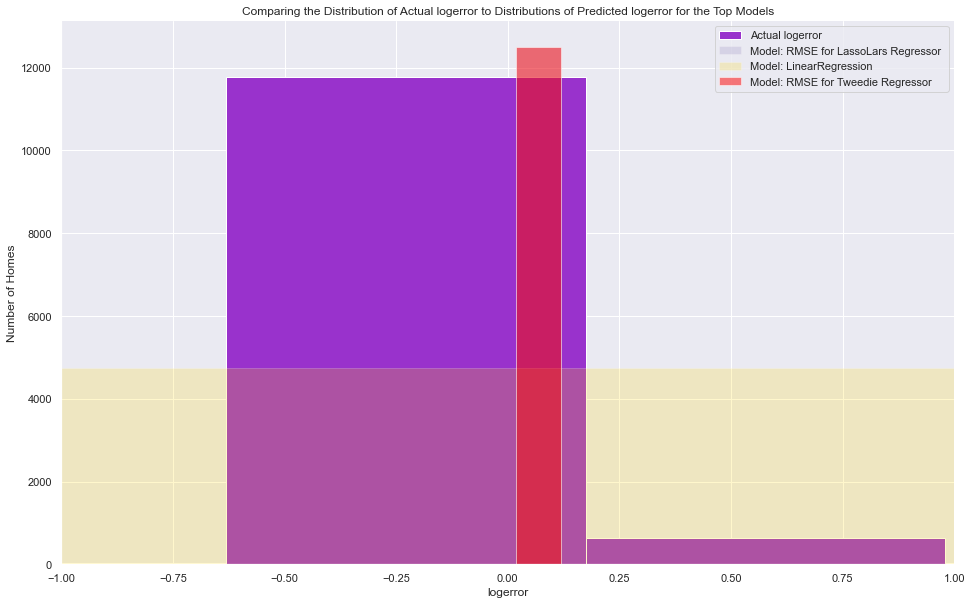

In [770]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,10))
plt.hist(y_validate.logerror, color='darkorchid', alpha=1, bins=10, label="Actual logerror")
# plt.hist(y_validate.logerror_pred_lm2, color='c', alpha=.7, bins=10, label="Model: RMSE for Polynomial Regressor degrees=2", ec='black')
# plt.hist(y_validate.logerror_pred_lm3, color='chartreuse', alpha=.2, bins=50, label="Model: RMSE for Polynomial Regressor degrees=3")
plt.hist(y_validate.logerror_pred_lars, color='m', alpha=.2, bins=10,label="Model: RMSE for LassoLars Regressor ")
plt.hist(y_validate.logerror_pred_lm, color='gold', alpha=.2, bins=10,label="Model: LinearRegression")
plt.hist(y_validate.logerror_pred_lars, color='red', alpha=.5, bins=10, label="Model: RMSE for Tweedie Regressor")

plt.xlim(-1, 1)
plt.xlabel("logerror")
plt.ylabel("Number of Homes")
plt.title("Comparing the Distribution of Actual logerror to Distributions of Predicted logerror for the Top Models")
plt.legend()
plt.show()

looks like my best model is the tweedie regressor

perform test model on test set


### Test

In [ ]:
y_test = pd.DataFrame(y_test)

#predict on test
y_test['logerror_pred_lm2'] = lm2.predict(X_test_degree2)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.home_value, y_test.home_value_pred_lm2)**(0.5)

print(f"""
    RMSE for Polynomial Regressor degrees=2
    
    Test/Out-of-Sample Performance: {round(rmse_test, 2)}
""")

In [773]:
# predict train
y_test['logerror_pred_glm'] = glm.predict(test_scaled)

# evaluate: rmse
rmse_test = mean_squared_error(y_train.logerror, y_train.logerror_pred_glm)**(0.5)

print(f"""
    RMSE for Tweedie Regressor 
    
    Test/Out-of-Sample Performance: {round(rmse_test, 3)}
""")


    RMSE for Tweedie Regressor 
    
    Test/Out-of-Sample Performance: 0.173



### Summary
Following the evaluation of the different models using my selected features, I found that the best performing model was the tweedie Regressor with. It beat the baseline rmse by .001 with a score of 0.173. Looks like it performs best when around the median logerror.

Next Steps: I would like to look at trimming down the number of features and utilizing only a select few that I felt were effective during feature enginneering. Potentially use the cluster feature and a few others in order to improve model performance.

In [403]:
kmeans_scaled.cluster_centers_

array([[ 1.30083550e-01,  1.91625176e-01,  8.33940234e-02,
         1.35169886e-01,  2.57753339e-01,  8.55492642e-01,
         9.89335352e-04,  2.36563258e-01,  2.26974823e-02,
         1.22344318e-02,  8.04295868e-03,  1.17222017e-02,
         8.02867998e-03,  6.07072824e-01,  3.45538326e-02,
         3.17176401e-01,  3.63069993e-02,  1.25278509e-01,
         7.69181667e-02,  1.85315429e-01,  1.02428131e-02,
        -4.44089210e-16,  1.00000000e+00, -9.29811783e-16,
         2.00000000e+00],
       [ 9.73994601e-02,  1.46923877e-01,  5.13413829e-02,
        -9.02056208e-17,  4.74619935e-01,  6.47553449e-01,
         1.60581203e-03, -7.49400542e-16,  1.28512119e-02,
         7.58531792e-03,  5.23404885e-03,  7.97593503e-03,
         5.21278657e-03,  5.98868325e-01,  4.05702233e-02,
         5.26396454e-01,  3.42892080e-02,  1.06931427e-01,
         9.15933995e-16,  8.07030509e-02,  1.66609442e-03,
         1.00000000e+00,  3.16413562e-15, -1.08246745e-15,
         1.00000000e+00],
    

In [404]:
centroids = pd.DataFrame(kmeans_scaled.cluster_centers_, columns=train_scaled.columns)
centroids

,bathrooms,bedrooms,sqft,garagecarcnt,latitude,longitude,lotsizesquarefeet,poolcnt,structuretaxvaluedollarcnt,home_value,...,age,cost_per_sqft,sqft_room_ratio,airconditioning_encoded,luxury_score,luxury_sqft_per_age,LA,Orange,Ventura,cluster
0,0.13,0.19,0.08,0.14,0.26,0.86,0.00,0.24,0.02,0.01,...,0.32,0.04,0.13,0.08,0.19,0.01,-0.00,1.00,-0.00,2.00
1,0.10,0.15,0.05,-0.00,0.47,0.65,0.00,-0.00,0.01,0.01,...,0.53,0.03,0.11,0.00,0.08,0.00,1.00,0.00,-0.00,1.00
2,0.16,0.21,0.10,-0.00,0.55,0.61,0.00,1.00,0.04,0.02,...,0.40,0.04,0.14,0.52,0.20,0.01,1.00,-0.00,-0.00,4.00
3,0.15,0.19,0.08,-0.00,0.65,0.65,0.00,0.00,0.02,0.01,...,0.30,0.03,0.12,1.00,0.19,0.01,1.00,-0.00,-0.00,0.00
4,0.13,0.20,0.08,0.14,0.62,0.26,0.00,0.20,0.03,0.01,...,0.31,0.03,0.12,-0.00,0.18,0.01,-0.00,-0.00,1.00,3.00


Text(0.5, 1.0, 'Visualizing Cluster Centers')

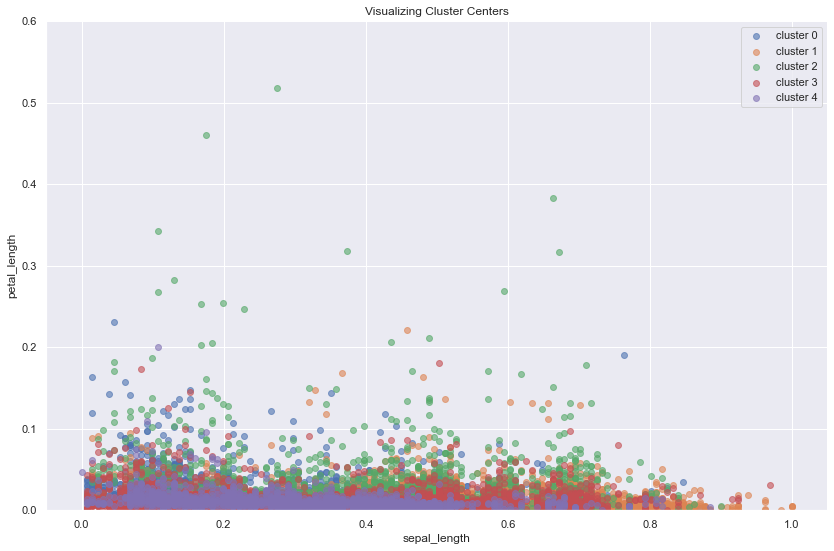

In [417]:
plt.figure(figsize=(14, 9))

for cluster, subset in train_scaled.groupby('cluster'):
    plt.scatter(subset.age, subset.home_value, label='cluster ' + str(cluster), alpha=.6)

# centroids.plot.scatter(y=kmeans_scaled,x=train_scaled, c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

plt.legend()
plt.xlabel('sepal_length')
plt.ylim(0,.6)
plt.ylabel('petal_length')
plt.title('Visualizing Cluster Centers')

In [394]:
pip install viz-python-lib

  Created wheel for pylibscrypt: filename=pylibscrypt-1.8.0-py3-none-any.whl size=37706 sha256=4a69954cd6d129888a51b4b0bfba115c8f610690a8f7adaf2780ae255d38ffb2
  Stored in directory: c:\users\timmy\appdata\local\pip\cache\wheels\f9\f2\a7\7be4fd80e7fa9c5c0e3ccfa235f609f30c291898910a7ca431
  Created wheel for toolz: filename=toolz-0.10.0-py3-none-any.whl size=55585 sha256=f2a070dd373c043d73fca0ffa81f6e09ba753aade0c408cdefde93a610ca4e9c
  Stored in directory: c:\users\timmy\appdata\local\pip\cache\wheels\94\d2\cb\924f740a8abd73e3f1d05cc4607ad12e15378f26ce47f4a20a
Successfully built pylibscrypt toolz
  Attempting uninstall: toolz
    Found existing installation: toolz 0.11.2
    Uninstalling toolz-0.11.2:
      Successfully uninstalled toolz-0.11.2
Note: you may need to restart the kernel to use updated packages.


In [ ]:
#columbs to drop
['parcelid', 'logerror', 'fips', 'fullbathcnt', 'regionidcity', 'regionidzip', 'yearbuilt', 'transactiondate',
 'airconditioningdesc', 'heatingorsystemdesc', 'quarter']

In [ ]:
# ['parcelid',
# #  'bathrooms',
# #  'bedrooms',
# #  'sqft',
#  'fips',
#  'fullbathcnt',
#  'garagecarcnt',
# #  'latitude',
# #  'longitude',
# #  'lotsizesquarefeet',
#  'poolcnt',
#  'regionidcity',
#  'regionidzip',
#  'yearbuilt',
# #  'structuretaxvaluedollarcnt',
# #  'home_value',
# #  'landtaxvaluedollarcnt',
# #  'taxamount',
#  'transactiondate',
#  'airconditioningdesc',
#  'heatingorsystemdesc',
# #  'home_value_structure_tax_difference',
# #  'hvs_pct',
# #  'taxrate',
# #  'age',
# #  'cost_per_sqft',
# #  'sqft_room_ratio',
# #  'airconditioning_encoded',
# #  'luxury_score',
# #  'luxury_sqft_per_age',
# #  'LA',
# #  'Orange',
# #  'Ventura',
#  'quarter']

In [ ]:
# # the variables that still need scaling
# scaled_vars = ['latitude', 'longitude', 'bathroomcnt', 'taxrate']

# # create new column names for the scaled variables by adding 'scaled_' to the beginning of each variable name 
# scaled_column_names = ['scaled_' + i for i in scaled_vars]

# # select the X partitions: [X_train, X_validate, X_test]
# X = partitions[1:4]

# # fit the minmaxscaler to X_train
# X_train = X[0]
# scaler = MinMaxScaler(copy=True).fit(X_train[scaled_vars])


# def scale_and_concat(df):
#     scaled_array = scaler.transform(df[scaled_vars])
#     scaled_df = pd.DataFrame(scaled_array, columns=scaled_column_names, index=df.index.values)
#     return pd.concat((df, scaled_df), axis=1)

# for i in range(len(X)):
#     X[i] = scale_and_concat(X[i])

In [323]:
# # the variables that still need scaling
# scaled_vars = ['bathrooms', 'bedrooms', 'sqft', 'fullbathcnt', 'garagecarcnt', 'latitude', 'longitude',
#  'lotsizesquarefeet', 'poolcnt','yearbuilt', 'structuretaxvaluedollarcnt',
#  'home_value', 'landtaxvaluedollarcnt', 'taxamount','home_value_structure_tax_difference',
#  'hvs_pct', 'taxrate', 'age', 'cost_per_sqft', 'sqft_room_ratio', 'airconditioning_encoded',
#  'luxury_score', 'luxury_sqft_per_age', 'LA', 'Orange', 'Ventura']

# # create new column names for the scaled variables by adding 'scaled_' to the beginning of each variable name 
# scaled_column_names = ['scaled_' + i for i in scaled_vars]

# # select the X partitions: [X_train, X_validate, X_test]
# X = partitions[1:4]

# # fit the minmaxscaler to X_train
# X_train = X[0]
# scaler = MinMaxScaler(copy=True).fit(X_train[scaled_vars])


# def scale_and_concat(df):
#     scaled_array = scaler.transform(df[scaled_vars])
#     scaled_df = pd.DataFrame(scaled_array, columns=scaled_column_names, index=df.index.values)
#     return pd.concat((df, scaled_df), axis=1)

# for i in range(len(X)):
#     X[i] = scale_and_concat(X[i])

In [331]:
# # the variables that still need scaling
# scaled_vars = ['bathrooms', 'bedrooms', 'sqft', 'fullbathcnt', 'garagecarcnt', 'latitude', 'longitude',
#  'lotsizesquarefeet', 'poolcnt','yearbuilt', 'structuretaxvaluedollarcnt',
#  'home_value', 'landtaxvaluedollarcnt', 'taxamount','home_value_structure_tax_difference',
#  'hvs_pct', 'taxrate', 'age', 'cost_per_sqft', 'sqft_room_ratio', 'airconditioning_encoded',
#  'luxury_score', 'luxury_sqft_per_age', 'LA', 'Orange', 'Ventura']

In [332]:
# # create new column names for the scaled variables by adding 'scaled_' to the beginning of each variable name 
# scaled_column_names = ['scaled_' + i for i in scaled_vars]

In [333]:
# # select the X partitions: [X_train, X_validate, X_test]
# X = partitions[1:4]


In [334]:
# # fit the minmaxscaler to X_train
# X_train = X[1]
# scaler = MinMaxScaler(copy=True).fit(X_train[scaled_vars])

In [335]:
# def scale_and_concat(df):
#     scaled_array = scaler.transform(df[scaled_vars])
#     scaled_df = pd.DataFrame(scaled_array, columns=scaled_column_names, index=df.index.values)
#     return pd.concat((df, scaled_df), axis=1)

In [336]:
# for i in range(len(X)):
#     X[i] = scale_and_concat(X[i])

In [338]:
# # recall: X[0] is X_train, X[1] is X_validate and X[2] is X_test
# X[1].describe()

,parcelid,bathrooms,bedrooms,sqft,fullbathcnt,garagecarcnt,latitude,longitude,lotsizesquarefeet,poolcnt,...,scaled_taxrate,scaled_age,scaled_cost_per_sqft,scaled_sqft_room_ratio,scaled_airconditioning_encoded,scaled_luxury_score,scaled_luxury_sqft_per_age,scaled_LA,scaled_Orange,scaled_Ventura
count,"12,509.00","12,509.00","12,509.00","12,509.00","12,509.00","12,509.00","12,509.00","12,509.00","12,509.00","12,509.00",...,"12,509.00","12,509.00","12,509.00","12,509.00","12,509.00","12,509.00","12,509.00","12,509.00","12,509.00","12,509.00"
mean,"12,963,687.52",2.24,3.31,"1,926.42",2.23,0.68,"34,019,815.71","-118,193,279.44","10,644.59",0.21,...,0.04,0.40,0.03,0.12,0.24,0.15,0.01,0.64,0.27,0.09
std,"2,204,168.13",0.98,0.93,989.41,0.97,0.98,"274,197.81","358,287.47","67,805.47",0.41,...,0.02,0.18,0.03,0.05,0.42,0.08,0.02,0.48,0.45,0.28
min,"10,711,888.00",0.00,1.00,360.00,0.00,0.00,"33,340,620.00","-119,310,447.00",236.00,0.00,...,0.00,0.00,-0.00,0.01,0.00,-0.03,0.00,0.00,0.00,0.00
25%,"11,510,531.00",2.00,3.00,"1,269.00",2.00,0.00,"33,824,036.00","-118,399,308.00","5,600.00",0.00,...,0.03,0.28,0.02,0.09,0.00,0.09,0.00,0.00,0.00,0.00
50%,"12,573,470.00",2.00,3.00,"1,670.00",2.00,0.00,"34,025,828.00","-118,155,819.00","6,838.00",0.00,...,0.04,0.42,0.03,0.11,0.00,0.15,0.00,1.00,0.00,0.00
75%,"14,138,952.00",3.00,4.00,"2,327.00",3.00,2.00,"34,187,915.00","-117,928,584.00","8,705.00",0.00,...,0.04,0.50,0.04,0.14,0.50,0.21,0.01,1.00,1.00,0.00
max,"162,960,529.00",11.00,10.00,"17,245.00",11.00,11.00,"34,818,767.00","-117,559,817.00","6,971,010.00",1.00,...,1.43,1.00,0.74,1.21,1.00,0.73,0.41,1.00,1.00,1.00


In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52119 entries, 0 to 52318
Data columns (total 32 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   parcelid                             52119 non-null  int64  
 1   bathrooms                            52119 non-null  int32  
 2   bedrooms                             52119 non-null  int32  
 3   sqft                                 52119 non-null  int32  
 4   fips                                 52119 non-null  object 
 5   fullbathcnt                          52119 non-null  float64
 6   garagecarcnt                         52119 non-null  int32  
 7   latitude                             52119 non-null  float64
 8   longitude                            52119 non-null  float64
 9   lotsizesquarefeet                    52119 non-null  float64
 10  poolcnt                              52119 non-null  int32  
 11  regionidcity                

In [109]:
df.airconditioningdesc.value_counts()

None         38684
Central      11852
Yes           1567
Wall Unit       16
Name: airconditioningdesc, dtype: int64

In [110]:
df.airconditioningdesc.isna().value_counts()

False    52119
Name: airconditioningdesc, dtype: int64

In [111]:
df.poolcnt.value_counts()

0    41065
1    11054
Name: poolcnt, dtype: int64

In [112]:
df.poolcnt.isna().value_counts()

False    52119
Name: poolcnt, dtype: int64

In [113]:
df.garagecarcnt.value_counts()

0     34235
2     14750
1      2195
3       618
4       251
5        45
6        12
7         3
10        3
8         2
9         2
11        1
13        1
14        1
Name: garagecarcnt, dtype: int64

In [114]:
# df=df.rename(columns={"bedroomcnt": "bedrooms", "bathroomcnt": "bathrooms", "calculatedfinishedsquarefeet": "sqft","taxvaluedollarcnt": "home_value"})

In [115]:
# #filled null/Nonetype with 'None' or '0'
# df.heatingorsystemdesc= df.heatingorsystemdesc.fillna('None')
# df.airconditioningdesc= df.airconditioningdesc.fillna('None')
# df.poolcnt= df.poolcnt.fillna('0')
# df.garagecarcnt = df.garagecarcnt.fillna('0')
# df.isna().sum()

In [116]:
# #need to drop rows where bedrooms = 0
# df[df.bedrooms == 0]
# df = df[df.bedrooms != 0]

In [117]:
# #feature engineering
# df['home_value_structure_tax_difference']= (df['home_value']-df['structuretaxvaluedollarcnt'])
# df.home_value_structure_tax_difference.describe()

In [118]:
# #feature engineering
# df['hvs_pct'] = (df['home_value_structure_tax_difference']/df['home_value'])

In [119]:
# #will use the value to impute missing structuretaxvaluedollarcnt
# df.hvs_pct.mean()

In [120]:
# df.structuretaxvaluedollarcnt = df.structuretaxvaluedollarcnt.fillna(df['home_value']*df['hvs_pct'].mean())
# df[df['structuretaxvaluedollarcnt'].isna()]

In [121]:
# df[df.taxamount.isna()]

In [122]:
# #feature engineering
# df['taxrate'] = (df['taxamount']/df['home_value'])
# df.taxrate.mean()

In [123]:
# #impute 4 missing values for taxamount using mean taxrate of feature engineering
# df.taxamount = df.taxamount.fillna(df['home_value']*df['taxrate'].mean())
# df.taxamount.isna().sum()

In [124]:
# # df[df.bathrooms == 0]
# df.bathrooms.mean()

In [125]:
# #impute null 0 bathrooms with mean
# df.bathrooms = df.bathrooms.fillna(2.0)

In [126]:
# df.fullbathcnt= df.fullbathcnt.fillna(df.bathrooms)

In [127]:
df.fullbathcnt.isna().sum()

0

In [128]:
# df.bathrooms.replace(0, 2, inplace=True)

In [129]:
# df[df.bathrooms == 0]

In [130]:
# #impute null regionidcity with mode
# df.regionidcity.value_counts()

In [131]:
# df['regionidcity'] = df.regionidcity.fillna(12447)
# df.regionidcity.isna().sum()

In [132]:
# df.home_value_structure_tax_difference.isna().sum()

In [133]:
# #impute missing values with below
# df.home_value_structure_tax_difference = df.home_value_structure_tax_difference.fillna(df['home_value']-df['structuretaxvaluedollarcnt'])
# df.home_value_structure_tax_difference.isna().sum()

In [134]:
# df.hvs_pct.isna().sum()

In [135]:
# # impute missing values with below
# df.hvs_pct = df.hvs_pct.fillna(df['home_value_structure_tax_difference']/df['home_value'])
# df.hvs_pct.isna().sum()

In [136]:
# df.hvs_pct.isna().sum()

In [137]:
# df.isna().sum()

In [138]:
# df[df.yearbuilt.isna()]

In [139]:
#impute nulls with mean year built
# df.yearbuilt = df.yearbuilt.fillna(df['yearbuilt'].mean())
# df.yearbuilt.isna().sum()

In [140]:
# df.yearbuilt.mode()

In [141]:
# df.regionidzip.mode()

In [142]:
# #impute nulls with mode of regionidzip
# df.regionidzip = df.regionidzip.fillna(97_319)
# df.regionidzip.isna().sum()

In [143]:
# df.regionidcity.mode()

In [144]:
# df.lotsizesquarefeet.median()

In [145]:
# #replace nulls with median lot size
# df.lotsizesquarefeet = df.lotsizesquarefeet.fillna(df.lotsizesquarefeet.median())
# df.lotsizesquarefeet.isna().sum()

In [146]:
#impute fullbathcnt with value from df.bathrooms
# df.fullbathcnt = df.fullbathcnt.fillna(df.bathrooms)

In [147]:
# df.isna().sum()

In [148]:
#drop remaining handful of nulls
# df = df.dropna()

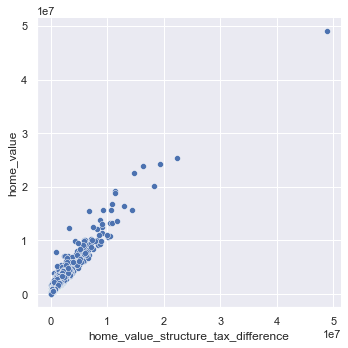

In [210]:
sns.relplot(x=df.home_value_structure_tax_difference, y=df.home_value, data=df, palette='deep', legend='auto', kind='scatter', height=5, aspect=1, facet_kws=None, units=None, )

In [ ]:
# round(df.dropna().shape[0] / df.shape[0], 4)

In [150]:
sns.set_theme()

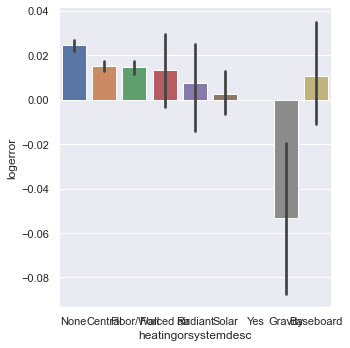

In [212]:
sns.catplot(data=df, kind="bar", x="heatingorsystemdesc", y="logerror")

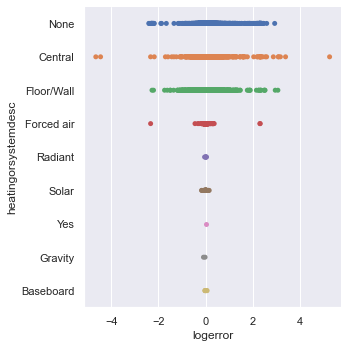

In [153]:
sns.catplot(x="logerror", y="heatingorsystemdesc", jitter=False, data=df)

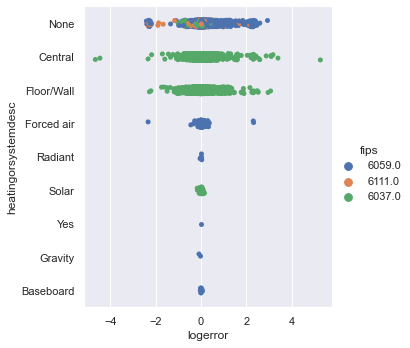

In [192]:

sns.catplot(x="logerror", y="heatingorsystemdesc", hue='fips', data=df)

<AxesSubplot:xlabel='logerror', ylabel='heatingorsystemdesc'>

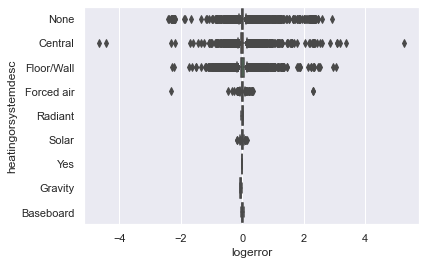

In [191]:

sns.boxplot(x="logerror", y="heatingorsystemdesc", data=df)

In [ ]:
# print("LA County Verified: ", df[df.fips==6037]['fips'].count() == df.LA.sum())
# print("Orange County Verified: ", df[df.fips==6059]['fips'].count() == df.Orange.sum())
# print("Ventura County Verified: ", df[df.fips==6111]['fips'].count() == df.Ventura.sum())

In [ ]:
#feature engineering
# df['age'] = 2017 - df.yearbuilt

In [ ]:
#feature engineering
#luxuryscore will be counts for pool, garage, ac, number of bathrooms and bedrooms
# df['luxury_score'] = (df['poolcnt']+df['garagecarcnt']+df['bedrooms']+df['bathrooms']+df['airconditioning_encoded'])

In [ ]:
# mapping = {"None" : "0",
#                      "Central" : "2",
#                      "Yes" : "1",
#                      "Wall Unit" : "1",
#                      }
# print(mapping)

In [156]:
# def get_counties():
#     '''
#     This function will create dummy variables out of the original fips column. 
#     And return a dataframe with all of the original columns except regionidcounty.
#     We will keep fips column for data validation after making changes. 
#     New columns added will be 'LA', 'Orange', and 'Ventura' which are boolean 
#     The fips ids are renamed to be the name of the county each represents. 
#     '''
#     # create dummy vars of fips id
#     county_df = pd.get_dummies(df.fips)
#     # rename columns by actual county name
#     county_df.columns = ['LA', 'Orange', 'Ventura']
#     # concatenate the dataframe with the 3 county columns to the original dataframe
#     df_dummies = pd.concat([df, county_df], axis = 1)
#     # drop regionidcounty and fips columns
#     df_dummies = df_dummies.drop(columns = ['regionidcounty'])
#     return df_dummies

In [157]:
# df = get_counties()
# df.head().T

,0,1,2,3,4
parcelid,14297519,17052889,14186244,12177905,12095076
bathrooms,3,1,2,3,3
bedrooms,4,2,3,4,4
sqft,3100,1465,1243,2376,2962
fips,6059.0,6111.0,6059.0,6037.0,6037.0
fullbathcnt,3.00,1.00,2.00,3.00,3.00
garagecarcnt,2,1,2,0,0
latitude,"33,634,931.00","34,449,266.00","33,886,168.00","34,245,180.00","34,145,202.00"
longitude,"-117,869,207.00","-119,281,531.00","-117,823,170.00","-118,240,722.00","-118,179,824.00"
lotsizesquarefeet,"4,506.00","12,647.00","8,432.00","13,038.00","63,000.00"


In [ ]:
# df['airconditioning_encoded'] = df['airconditioningdesc'].map(mapping)

In [ ]:
# def optimize_types(df):
#     # Convert some columns to integers
#     # fips, yearbuilt, and bedrooms can be integers
#     df["fips"] = df["fips"].astype(str)
#     df["yearbuilt"] = df["yearbuilt"].astype(int)
#     df["bedrooms"] = df["bedrooms"].astype(int)
#     df["bathrooms"] = df["bathrooms"].astype(int)
#     df["home_value"] = df["home_value"].astype(int)
#     df["garagecarcnt"] = df["garagecarcnt"].astype(int)
#     df["poolcnt"] = df["poolcnt"].astype(int)
# #     df["heatingorsystemdesc"] = df["heatingorsystemdesc"].astype(int)
#     df["airconditioning_encoded"] = df["airconditioning_encoded"].astype(int)
    
    
    
#     df["sqft"] = df["sqft"].astype(int)
    
    
    
    
#     return df

In [ ]:
# df = optimize_types(df)

In [ ]:
#feature engineering luxury score/age*sqft
# df['luxury_sqft_per_age']= (df['luxury_score']*df['sqft']/df['age'])

In [ ]:
# def get_counties():
#     '''
#     This function will create dummy variables out of the original fips column. 
#     And return a dataframe with all of the original columns except regionidcounty.
#     We will keep fips column for data validation after making changes. 
#     New columns added will be 'LA', 'Orange', and 'Ventura' which are boolean 
#     The fips ids are renamed to be the name of the county each represents. 
#     '''
#     # create dummy vars of fips id
#     county_df = pd.get_dummies(df.fips)
#     # rename columns by actual county name
#     county_df.columns = ['LA', 'Orange', 'Ventura']
#     # concatenate the dataframe with the 3 county columns to the original dataframe
#     df_dummies = pd.concat([df, county_df], axis = 1)
#     # drop regionidcounty and fips columns
#     df_dummies = df_dummies.drop(columns = ['regionidcounty'])
#     return df_dummies

#### Handling Outliers
Note your use case

z-score: appropriate for normal data (normally distributed)

Tukey IQR method: not contingent on normality

Tukey Interquartile Range (IQR) Method:

    -Calculate IQR
      -Get Q3 and Q1
      -Get difference (q3-q1)
       -Establish "fences":
        -Standard inner fence: k = 1.5
        -Standard outer fence: k = 3.0
        -Upper bound: q3 + k * IQR
        -Lower bound: q1 - k * IQR

In [ ]:
def get_upper_outliers(s, k=1.5):
    '''
    Given a series and a cutoff value, k, returns the upper outliers for the
    series.

    The values returned will be either 0 (if the point is not an outlier), or a
    number that indicates how far away from the upper bound the observation is.
    '''
    q1, q3 = s.quantile([.25, 0.75])
    iqr = q3 - q1
    upper_bound = q3 + k * iqr
    return s.apply(lambda x: max([x - upper_bound, 0]))

In [ ]:
def add_upper_outlier_columns(df, k=1.5):
    '''
    Add a column with the suffix _outliers for all the numeric columns
    in the given dataframe.
    '''
    for col in df.select_dtypes('number'):
        df[col + '_outliers_upper'] = get_upper_outliers(df[col], k)
    return df

In [ ]:
df = add_upper_outlier_columns(df)

Mall customers

Question 1

Acquire data from the customers table in the mall_customers database.

In [ ]:

#Define a query for the mall dataset
mall_query = '''
             SELECT *
             FROM customers
             '''

In [ ]:
#Create the url to access the database
mall_database = 'mall_customers'

mall_url = wr.get_db_url(mall_database)

In [ ]:
#Read in the dataset
mall_df = pd.read_sql(mall_query, mall_url)

mall_df.head()

In [ ]:
# Question 2
# Summarize the data (include distributions and descriptive statistics).

In [ ]:
#Visualize distribution of target variable
plt.hist(mall_df['spending_score'])

In [ ]:
#Descriptive statistics of numerical columns
mall_df.describe().T

In [ ]:
mall_df.isna().sum()

In [ ]:
#See the quantiles for age
mall_df['age'].quantile([0.25, 0.75])

In [ ]:
#Store the quantiles in variables
age_q1, age_q3 = mall_df['age'].quantile([0.25, 0.75])

In [ ]:
#Calculate the IQR
age_iqr = age_q3 - age_q1

age_iqr

In [ ]:
#Calculate upper and lower bounds based on a k value of 1.5
age_upper = age_q3 + (age_iqr * 1.5)
age_lower = age_q1 - (age_iqr * 1.5)

age_upper, age_lower

In [ ]:
#Check for outliers in the age column
mall_df[mall_df['age'] > age_upper]

In [ ]:
# Question 4
# Split data into train, validate, and test.

In [ ]:
#Split my data into three subsets
seed = 42

mall_train, test_val = train_test_split(mall_df, train_size=0.7,
                                   random_state=seed)

mall_test, mall_val = train_test_split(test_val, train_size=0.5,
                                       random_state=seed)

mall_train.shape, mall_val.shape, mall_test.shape

In [ ]:
# Question 5
# Encode categorical columns using a one hot encoder (pd.get_dummies).

In [ ]:
#Check get_dummies works as expected on my training data
pd.get_dummies(mall_train)

In [ ]:
#Create the dataframe with dummies for gender and drop redundant column
mall_train = pd.get_dummies(mall_train)

mall_train.drop(columns=['gender_Male'], inplace=True)

mall_train.head()

In [ ]:
# Question 6
# Handle missing values.

In [ ]:
#Check for missing values
mall_train.info()

In [ ]:
# Question 7
# Scaling

In [ ]:
#Initialize the scaler and fit/transform a couple columns in my training data
mms = MinMaxScaler()

mall_train[['age', 'annual_income']] = mms.fit_transform(mall_train[['age',
                                                                     'annual_income']])

mall_train.head()